In [1]:
from collections import Counter
import os
from glob import glob
import re
import numbers

from graphviz import Source
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
import networkx as nx
import numpy as np
from scipy import stats
import pandas as pd
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter



sns.set_style('white')
sns.set_context('notebook')

def plot_style(figsize=(12, 6), labelsize=20, titlesize=24, ticklabelsize=14, **kwargs):
   basic_style = {
       'figure.figsize': figsize,
       'axes.labelsize': labelsize,
       'axes.titlesize': titlesize,
       'xtick.labelsize': ticklabelsize,
       'ytick.labelsize': ticklabelsize,
       'axes.spines.top': False,
       'axes.spines.right': False,
       'axes.spines.left': False,
       'axes.grid': False,
       'axes.grid.axis': 'y',
   }
   basic_style.update(kwargs)
   return plt.rc_context(rc=basic_style)

blue = sns.xkcd_rgb['ocean blue']

## Create df with performance data

### Clone map

In [2]:
data = [['bulk', 's0', 'P3861_218.clean.dedup_ac.txt', 'ss0'], 
        ['E', 's1', 'P9855_2085_S108_L004_ac.txt', 'ss1'],
        ['A', 's2', 'P9855_2089_S112_L004_ac.txt', 'ss2'],
        ['A', 's3', 'P9855_2090_S113_L004_ac.txt', 'ss3'],
        ['D', 's4', 'P9855_2091_S114_L004_ac.txt', 'ss4'],
        ['E', 's5', 'P9855_2093_S116_L005_ac.txt', 'ss5'],
        ['D', 's6', 'P9855_2096_S119_L005_ac.txt', 'ss6'],
        ['F', 's7', 'P9855_2101_S124_L006_ac.txt', 'ss7'],
        ['F', 's8', 'P9855_2102_S125_L006_ac.txt', 'ss8'],
        ['B', 's9', 'P9855_2104_S127_L006_ac.txt', 'ss9'],
        ['C', 's10', 'P9855_2110_S133_L007_ac.txt', 'ss10'],
        ['C', 's11', 'P9855_2111_S134_L007_ac.txt', 'ss11'],
        ['B', 's12', 'P9855_2112_S135_L007_ac.txt', 'ss12']]

clones_map_raw = pd.DataFrame(data, columns=['clone', 'tree_id', 'cell_id', 'node_name'])

clones_map_raw

clone tree_id                       cell_id node_name
0   bulk      s0  P3861_218.clean.dedup_ac.txt       ss0
1      E      s1   P9855_2085_S108_L004_ac.txt       ss1
2      A      s2   P9855_2089_S112_L004_ac.txt       ss2
3      A      s3   P9855_2090_S113_L004_ac.txt       ss3
4      D      s4   P9855_2091_S114_L004_ac.txt       ss4
5      E      s5   P9855_2093_S116_L005_ac.txt       ss5
6      D      s6   P9855_2096_S119_L005_ac.txt       ss6
7      F      s7   P9855_2101_S124_L006_ac.txt       ss7
8      F      s8   P9855_2102_S125_L006_ac.txt       ss8
9      B      s9   P9855_2104_S127_L006_ac.txt       ss9
10     C     s10   P9855_2110_S133_L007_ac.txt      ss10
11     C     s11   P9855_2111_S134_L007_ac.txt      ss11
12     B     s12   P9855_2112_S135_L007_ac.txt      ss12

In [3]:
clones_map = dict(clones_map_raw[['tree_id', 'clone']].values)
all_clones = list(clones_map_raw.clone.unique())

In [4]:
n_samples_per_clone = clones_map_raw.clone.value_counts()
n_samples_per_clone

E       2
A       2
D       2
F       2
B       2
C       2
bulk    1
Name: clone, dtype: int64

### Load info from mt-SCITE runs

In [5]:
scite_input_path = f'../../../mt-SCITE/mt-SCITE_output/P9855/stdout/'

scite_stdout_filenames = list(glob(os.path.join(scite_input_path, '*.txt')))

# Get log likelihood scores and n trees
exp_std = []
lhood = []
n_trees = []

#for filename in sorted(scite_stdout_filenames, key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)]):
for filename in sorted(scite_stdout_filenames):
    #print(filename)
    name = os.path.basename(filename).rsplit('.', 1)[0].rsplit('.', 1)[0]
    #print(name)
    exp_std.append(name)
    #print(files)
    file = open(filename, "r")
    for line in file:
        if 'best log score for tree:' in line:
            score = line.split('	')[1].rstrip()
            lhood.append(score)
            lhood = [float(x) for x in lhood]
            #print(lhood)
        if 'opt tree' in line:
            n = line.split(' opt')[0].lstrip()
            n_trees.append(n)
            n_trees = [int(x) for x in n_trees]
            #print(n_trees)

In [6]:
print(len(exp_std))
print(len(lhood))

540
540


### Load info from pmats

In [7]:

pmat_input_path = f'../../data/P9855_matrix_output/'

pmats = list(glob(os.path.join(pmat_input_path, '*.csv')))

pmat_names = []
n_pmat_rows = []

for filename in sorted(pmats):
#for filename in sorted(pmats, key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)]):
    name = os.path.basename(filename).rsplit('.', 1)[0]
    print(name)
    file = open(filename, "r")
    n = len(file.readlines())
    n_pmat_rows.append(n)
    pmat_names.append(name)

# store in a dict
pmat_info = {pmat_names[i]: n_pmat_rows[i] for i in range(len(pmat_names))}


0.0001
0.0002
0.0003
0.0004
0.0005
0.0006
0.0007
0.0008
0.0009
0.001
0.0011
0.0012
0.0013
0.0014
0.0015
0.0016
0.0017
0.0018
0.0019
0.002
0.0021
0.0031
0.0041
0.0051
0.0061
0.0071
0.0081
0.0091
0.0101
0.0111
0.0121
0.0131
0.0141
0.0151
0.0161
0.0171
0.0181
0.0191
0.0201
0.0211
0.0221
0.0231
0.0241
0.0251
0.0261
0.0271
0.0281
0.0291
0.0301
0.0311
0.0321
0.0331
0.0341
0.0351


In [8]:
len(pmats)

54

### Create df containing info from mt-SCITE and pmat

In [9]:
samples = 13

performance = pd.DataFrame(exp_std)
performance['lhood'] = lhood
performance['lhood'] = performance['lhood'].astype(float)

performance['n_trees'] = n_trees
performance['error_rate'] = performance[0].str.split('_').str.get(0)

performance = performance.rename(columns={0: 'run'})
performance = performance.set_index('run')

runs = performance.index.tolist()
performance = performance.sort_index()

performance['n_muts'] = performance['error_rate'].map(pmat_info)

performance['entries'] = performance['n_muts']*samples

performance['lhood_entries'] = performance['lhood']/performance['entries']

In [10]:
performance

lhood  n_trees error_rate  n_muts  entries  lhood_entries
run                                                                       
0.0001_1  -1543.468818        1     0.0001     176     2288      -0.674593
0.0001_10 -1584.845425        8     0.0001     176     2288      -0.692677
0.0001_2  -1485.240456       34     0.0001     176     2288      -0.649144
0.0001_3  -1547.046870       33     0.0001     176     2288      -0.676157
0.0001_4  -1533.801790        9     0.0001     176     2288      -0.670368
...                ...      ...        ...     ...      ...            ...
0.0351_5     -2.367243        1     0.0351       2       26      -0.091048
0.0351_6     -2.367243        1     0.0351       2       26      -0.091048
0.0351_7     -2.367243        1     0.0351       2       26      -0.091048
0.0351_8     -2.367243        1     0.0351       2       26      -0.091048
0.0351_9     -2.367243        1     0.0351       2       26      -0.091048

[540 rows x 6 columns]

### Read trees

In [11]:
MAX_TREES_PER_ERROR_RATE = 100
all_trees = {}
for run, n in zip(runs, n_trees):
    all_trees[run] = []
    for idx in range(min(MAX_TREES_PER_ERROR_RATE, n)):
        #print(n)
        tree_filename = f'../../../mt-SCITE/mt-SCITE_output/P9855/{run}_map{idx}.gv' 
        tree = nx.drawing.nx_pydot.read_dot(tree_filename)
        #tree.remove_node('\\n')
        all_trees[run].append(tree)
        #print(error_rate)

In [12]:
def new_count_row(all_clone_names, clone_name=None):
    """ Create a DataFrame row with one entry per clone name. 
    
    If `clone_name` is not None, initialize that entry to 1.
    """
    row = pd.Series(data=0, index=all_clone_names)
    if clone_name is not None:
        row[clone_name] = 1
    return row

def dfs_clones_count(g, clones, all_clone_names, source_node):
    clones_count = pd.DataFrame({sample_name: new_count_row(all_clones, clone_name) for sample_name, clone_name in clones.items()})
    for pre_node, post_node, edge_label in nx.dfs_labeled_edges(g, source_node):
        if edge_label is not 'reverse' or pre_node == post_node: 
            continue
        pre_node_counter = clones_count.get(pre_node, new_count_row(all_clones))
        if post_node not in clones_count.columns:
            print('!! possible mutation in a leaf: not found', post_node)
            continue
        clones_count[pre_node] = pre_node_counter + clones_count[post_node]

    return clones_count

def purity(clones_count):
    return clones_count.div(clones_count.sum(axis=0), axis=1)

def get_root_node(t):
    root_nodes = [n for n,d in t.in_degree() if d==0]
    assert len(root_nodes) == 1
    root_node = root_nodes[0]
    return root_node

# Avg purity of nodes with >1 sample

In [13]:
import warnings
warnings.filterwarnings('ignore')

performance['avg_purity_more_than_one_sample'] = 0
performance['frac_purity_100_more_than_one_sample'] = 0
for error_rate, trees in all_trees.items():
    avg_purities = []
    frac_purities_100 = []
    #n_purities_100 = []
    for t in trees:
        #print(error_rate, get_root_node(t))
        clones_count = dfs_clones_count(t, clones_map, all_clones, source_node=get_root_node(t))
        print(clones_count)
        more_than_one_sample = clones_count.sum(axis=0) > 1
        p = purity(clones_count).loc[:, more_than_one_sample]
        #print(p)
        
        # exclude mutations shared by all clones
        p = p.T
        p = p.mask((p.A > 0) & (p.B > 0) & (p.C > 0) & (p.D > 0) & (p.E > 0) & (p.F > 0))
        p = p.dropna().T
        
        
        # Average purity
        avg_purity = p.max(axis=0).mean()
        avg_purities.append(avg_purity)
        #print(avg_purities)
        # Fraction of nodes with 100% purity
        is_purity_100 = np.isclose(p.max(axis=0), 1.0)
        frac_purity_100 = is_purity_100.sum() / is_purity_100.shape[0]
        frac_purities_100.append(frac_purity_100)

    performance.loc[error_rate, 'avg_purity_more_than_one_sample'] = avg_purities[0]
    performance.loc[error_rate, 'frac_purity_100_more_than_one_sample'] = frac_purities_100[0]

!! possible mutation in a leaf: not found 24
!! possible mutation in a leaf: not found 33
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  39  5  102  158  152  155  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0    0    0    0    0   
E      0   1   0   0   0   1   0   0   0   0  ...   2  2    2    2    2    2   
A      0   0   1   1   0   0   0   0   0   0  ...   2  2    2    2    2    2   
D      0   0   0   0   1   0   1   0   0   0  ...   2  2    2    2    2    2   
F      0   0   0   0   0   0   0   1   1   0  ...   2  2    2    2    2    2   
B      0   0   0   0   0   0   0   0   0   1  ...   2  2    2    2    2    2   
C      0   0   0   0   0   0   0   0   0   0  ...   2  2    2    2    2    2   

      81  110  97  177  
bulk   0    0   0    1  
E      2    2   2    2  
A      2    2   2    2  
D      2    2   2    2  
F      2    2   2    2  
B      2    2   2    2  
C      2    2   2    2  

[7 rows x 188 columns]
!! possible mutation in a leaf: not found 135

!! possible mutation in a leaf: not found 106
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  145  156  97  81  74  155  \
bulk   1   0   0   0   0   0   0   0   0   0  ...    0    0   0   0   0    0   
E      0   1   0   0   0   1   0   0   0   0  ...    2    2   2   2   2    2   
A      0   0   1   1   0   0   0   0   0   0  ...    2    2   2   2   2    2   
D      0   0   0   0   1   0   1   0   0   0  ...    2    2   2   2   2    2   
F      0   0   0   0   0   0   0   1   1   0  ...    2    2   2   2   2    2   
B      0   0   0   0   0   0   0   0   0   1  ...    2    2   2   2   2    2   
C      0   0   0   0   0   0   0   0   0   0  ...    2    2   2   2   2    2   

      134  51  102  177  
bulk    0   0    0    1  
E       2   2    2    2  
A       2   2    2    2  
D       2   2    2    2  
F       2   2    2    2  
B       2   2    2    2  
C       2   2    2    2  

[7 rows x 189 columns]
!! possible mutation in a leaf: not found 106
      s0  s1  s2  s3  s4  s5  s6  s

!! possible mutation in a leaf: not found 106
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  145  156  97  81  143  155  \
bulk   1   0   0   0   0   0   0   0   0   0  ...    0    0   0   0    0    0   
E      0   1   0   0   0   1   0   0   0   0  ...    2    2   2   2    2    2   
A      0   0   1   1   0   0   0   0   0   0  ...    2    2   2   2    2    2   
D      0   0   0   0   1   0   1   0   0   0  ...    2    2   2   2    2    2   
F      0   0   0   0   0   0   0   1   1   0  ...    2    2   2   2    2    2   
B      0   0   0   0   0   0   0   0   0   1  ...    2    2   2   2    2    2   
C      0   0   0   0   0   0   0   0   0   0  ...    2    2   2   2    2    2   

      134  51  102  177  
bulk    0   0    0    1  
E       2   2    2    2  
A       2   2    2    2  
D       2   2    2    2  
F       2   2    2    2  
B       2   2    2    2  
C       2   2    2    2  

[7 rows x 189 columns]
!! possible mutation in a leaf: not found 106
      s0  s1  s2  s3  s4  s

!! possible mutation in a leaf: not found 106
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  145  156  97  81  143  155  \
bulk   1   0   0   0   0   0   0   0   0   0  ...    0    0   0   0    0    0   
E      0   1   0   0   0   1   0   0   0   0  ...    2    2   2   2    2    2   
A      0   0   1   1   0   0   0   0   0   0  ...    2    2   2   2    2    2   
D      0   0   0   0   1   0   1   0   0   0  ...    2    2   2   2    2    2   
F      0   0   0   0   0   0   0   1   1   0  ...    2    2   2   2    2    2   
B      0   0   0   0   0   0   0   0   0   1  ...    2    2   2   2    2    2   
C      0   0   0   0   0   0   0   0   0   0  ...    2    2   2   2    2    2   

      134  51  102  177  
bulk    0   0    0    1  
E       2   2    2    2  
A       2   2    2    2  
D       2   2    2    2  
F       2   2    2    2  
B       2   2    2    2  
C       2   2    2    2  

[7 rows x 189 columns]
!! possible mutation in a leaf: not found 106
      s0  s1  s2  s3  s4  s

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  145  156  97  81  143  155  \
bulk   1   0   0   0   0   0   0   0   0   0  ...    0    0   0   0    0    0   
E      0   1   0   0   0   1   0   0   0   0  ...    2    2   2   2    2    2   
A      0   0   1   1   0   0   0   0   0   0  ...    2    2   2   2    2    2   
D      0   0   0   0   1   0   1   0   0   0  ...    2    2   2   2    2    2   
F      0   0   0   0   0   0   0   1   1   0  ...    2    2   2   2    2    2   
B      0   0   0   0   0   0   0   0   0   1  ...    2    2   2   2    2    2   
C      0   0   0   0   0   0   0   0   0   0  ...    2    2   2   2    2    2   

      134  51  102  177  
bulk    0   0    0    1  
E       2   2    2    2  
A       2   2    2    2  
D       2   2    2    2  
F       2   2    2    2  
B       2   2    2    2  
C       2   2    2    2  

[7 rows x 189 columns]
!! possible mutation in a leaf: not found 106
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  145  156  97  81  143 

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  143  95  81  39  145  51  \
bulk   1   0   0   0   0   0   0   0   0   0  ...    0   0   0   0    0   0   
E      0   1   0   0   0   1   0   0   0   0  ...    2   2   2   2    2   2   
A      0   0   1   1   0   0   0   0   0   0  ...    2   2   2   2    2   2   
D      0   0   0   0   1   0   1   0   0   0  ...    2   2   2   2    2   2   
F      0   0   0   0   0   0   0   1   1   0  ...    2   2   2   2    2   2   
B      0   0   0   0   0   0   0   0   0   1  ...    2   2   2   2    2   2   
C      0   0   0   0   0   0   0   0   0   0  ...    2   2   2   2    2   2   

      97  74  163  177  
bulk   0   0    0    1  
E      2   2    2    2  
A      2   2    2    2  
D      2   2    2    2  
F      2   2    2    2  
B      2   2    2    2  
C      2   2    2    2  

[7 rows x 190 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  143  95  81  39  145  51  \
bulk   1   0   0   0   0   0   0   0   0   0  ...    0   0   0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  143  95  81  39  145  51  \
bulk   1   0   0   0   0   0   0   0   0   0  ...    0   0   0   0    0   0   
E      0   1   0   0   0   1   0   0   0   0  ...    2   2   2   2    2   2   
A      0   0   1   1   0   0   0   0   0   0  ...    2   2   2   2    2   2   
D      0   0   0   0   1   0   1   0   0   0  ...    2   2   2   2    2   2   
F      0   0   0   0   0   0   0   1   1   0  ...    2   2   2   2    2   2   
B      0   0   0   0   0   0   0   0   0   1  ...    2   2   2   2    2   2   
C      0   0   0   0   0   0   0   0   0   0  ...    2   2   2   2    2   2   

      97  74  163  177  
bulk   0   0    0    1  
E      2   2    2    2  
A      2   2    2    2  
D      2   2    2    2  
F      2   2    2    2  
B      2   2    2    2  
C      2   2    2    2  

[7 rows x 190 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  143  95  81  39  145  51  \
bulk   1   0   0   0   0   0   0   0   0   0  ...    0   0   0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  143  95  81  163  145  51  \
bulk   1   0   0   0   0   0   0   0   0   0  ...    0   0   0    0    0   0   
E      0   1   0   0   0   1   0   0   0   0  ...    2   2   2    2    2   2   
A      0   0   1   1   0   0   0   0   0   0  ...    2   2   2    2    2   2   
D      0   0   0   0   1   0   1   0   0   0  ...    2   2   2    2    2   2   
F      0   0   0   0   0   0   0   1   1   0  ...    2   2   2    2    2   2   
B      0   0   0   0   0   0   0   0   0   1  ...    2   2   2    2    2   2   
C      0   0   0   0   0   0   0   0   0   0  ...    2   2   2    2    2   2   

      156  74  102  177  
bulk    0   0    0    1  
E       2   2    2    2  
A       2   2    2    2  
D       2   2    2    2  
F       2   2    2    2  
B       2   2    2    2  
C       2   2    2    2  

[7 rows x 190 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  143  95  81  163  145  51  \
bulk   1   0   0   0   0   0   0   0   0   0  .

!! possible mutation in a leaf: not found 174
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  128  134  74  39  51  156  \
bulk   1   0   0   0   0   0   0   0   0   0  ...    0    0   0   0   0    0   
E      0   1   0   0   0   1   0   0   0   0  ...    2    2   2   2   2    2   
A      0   0   1   1   0   0   0   0   0   0  ...    2    2   2   2   2    2   
D      0   0   0   0   1   0   1   0   0   0  ...    2    2   2   2   2    2   
F      0   0   0   0   0   0   0   1   1   0  ...    2    2   2   2   2    2   
B      0   0   0   0   0   0   0   0   0   1  ...    2    2   2   2   2    2   
C      0   0   0   0   0   0   0   0   0   0  ...    2    2   2   2   2    2   

      97  8  102  177  
bulk   0  0    0    1  
E      2  2    2    2  
A      2  2    2    2  
D      2  2    2    2  
F      2  2    2    2  
B      2  2    2    2  
C      2  2    2    2  

[7 rows x 189 columns]
!! possible mutation in a leaf: not found 174
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  

[7 rows x 188 columns]
!! possible mutation in a leaf: not found 33
!! possible mutation in a leaf: not found 135
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  145  128  39  143  102  97  \
bulk   1   0   0   0   0   0   0   0   0   0  ...    0    0   0    0    0   0   
E      0   1   0   0   0   1   0   0   0   0  ...    2    2   2    2    2   2   
A      0   0   1   1   0   0   0   0   0   0  ...    2    2   2    2    2   2   
D      0   0   0   0   1   0   1   0   0   0  ...    2    2   2    2    2   2   
F      0   0   0   0   0   0   0   1   1   0  ...    2    2   2    2    2   2   
B      0   0   0   0   0   0   0   0   0   1  ...    2    2   2    2    2   2   
C      0   0   0   0   0   0   0   0   0   0  ...    2    2   2    2    2   2   

      74  81  134  177  
bulk   0   0    0    1  
E      2   2    2    2  
A      2   2    2    2  
D      2   2    2    2  
F      2   2    2    2  
B      2   2    2    2  
C      2   2    2    2  

[7 rows x 188 columns]
!! possible m

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  155  145  95  97  74  81  \
bulk   1   0   0   0   0   0   0   0   0   0  ...    0    0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...    2    2   2   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...    2    2   2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...    2    2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...    2    2   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...    2    2   2   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...    2    2   2   2   2   2   

      134  102  51  177  
bulk    0    0   0    1  
E       2    2   2    2  
A       2    2   2    2  
D       2    2   2    2  
F       2    2   2    2  
B       2    2   2    2  
C       2    2   2    2  

[7 rows x 190 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  155  145  95  97  81  74  \
bulk   1   0   0   0   0   0   0   0   0   0  ...    0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  128  134  44  97  145  74  \
bulk   1   0   0   0   0   0   0   0   0   0  ...    0    0   0   0    0   0   
E      0   1   0   0   0   1   0   0   0   0  ...    2    2   2   2    2   2   
A      0   0   1   1   0   0   0   0   0   0  ...    2    2   2   2    2   2   
D      0   0   0   0   1   0   1   0   0   0  ...    2    2   2   2    2   2   
F      0   0   0   0   0   0   0   1   1   0  ...    2    2   2   2    2   2   
B      0   0   0   0   0   0   0   0   0   1  ...    2    2   2   2    2   2   
C      0   0   0   0   0   0   0   0   0   0  ...    2    2   2   2    2   2   

      95  81  51  177  
bulk   0   0   0    1  
E      2   2   2    2  
A      2   2   2    2  
D      2   2   2    2  
F      2   2   2    2  
B      2   2   2    2  
C      2   2   2    2  

[7 rows x 190 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  128  134  44  97  145  74  \
bulk   1   0   0   0   0   0   0   0   0   0  ...    0    0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  81  39  156  143  128  44  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0    0    0    0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   2    2    2    2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2    2    2    2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2   2    2    2    2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   2   2    2    2    2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   2   2    2    2    2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   2   2    2    2    2   2   

      155  145  97  177  
bulk    0    0   0    1  
E       2    2   2    2  
A       2    2   2    2  
D       2    2   2    2  
F       2    2   2    2  
B       2    2   2    2  
C       2    2   2    2  

[7 rows x 188 columns]
!! possible mutation in a leaf: not found 104
!! possible mutation in a leaf: not found 80
      s0  s1  s2  s3  s4  s5  s6  s7

!! possible mutation in a leaf: not found 104
!! possible mutation in a leaf: not found 80
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  81  39  156  143  128  44  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0    0    0    0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   2    2    2    2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2    2    2    2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2   2    2    2    2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   2   2    2    2    2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   2   2    2    2    2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   2   2    2    2    2   2   

      155  145  97  177  
bulk    0    0   0    1  
E       2    2   2    2  
A       2    2   2    2  
D       2    2   2    2  
F       2    2   2    2  
B       2    2   2    2  
C       2    2   2    2  

[7 rows x 188 columns]
!! possible mutation in a leaf: not 

!! possible mutation in a leaf: not found 80
!! possible mutation in a leaf: not found 104
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  81  39  156  143  128  44  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0    0    0    0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   2    2    2    2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2    2    2    2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2   2    2    2    2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   2   2    2    2    2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   2   2    2    2    2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   2   2    2    2    2   2   

      155  145  97  177  
bulk    0    0   0    1  
E       2    2   2    2  
A       2    2   2    2  
D       2    2   2    2  
F       2    2   2    2  
B       2    2   2    2  
C       2    2   2    2  

[7 rows x 188 columns]
!! possible mutation in a leaf: not 

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  26  28  39  30  27  46  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   2   2   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   2   2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   2   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   2   2   2   2   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   2   2   2   2   2   

      36  50  65  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 78 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  26  28  39  30  27  46  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  28  39  14  30  46  27  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   2   2   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   2   2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   2   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   2   2   2   2   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   2   2   2   2   2   

      36  50  65  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 78 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  28  39  14  30  46  27  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  28  50  14  30  46  27  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   2   2   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   2   2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   2   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   2   2   2   2   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   2   2   2   2   2   

      36  39  65  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 78 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  51  33  39  50  36  56  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  7  28  46  30  36  56  27  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0   2   2   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...  0   0   2   2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   2   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...  2   2   2   2   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   2   2   2   2   2   

      50  39  65  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 78 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  7  28  46  30  36  56  27  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  51  33  39  56  30  14  27  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   2   2   2   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   2   2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   2   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   2   2   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   2   2   2   2   2   

      46  50  65  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 78 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  51  33  39  56  30  14  27  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  26  34  12  22  32  25  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   2   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2   2   2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   0   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   2   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   2   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   2   2   2   2   

      20  37  41  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 54 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  26  34  12  37  32  25  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  2  23  31  10  24  25  20  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  2   2   2   2   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...  0   0   0   2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   0   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   2   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   2   2   2   2   

      22  37  41  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 54 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  2  23  31  10  24  25  20  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0

[7 rows x 54 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  9  34  12  20  10  32  25  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0   0   2   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   2   2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   0   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   2   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   2   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   2   2   2   2   

      22  37  41  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 54 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  9  34  12  20  10  32  25  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E 

[7 rows x 54 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  40  29  12  22  32  25  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   2   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   0   2   2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   0   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   1   1   2   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   2   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   2   2   2   2   

      20  37  41  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 54 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  28  35  38  22  32  37  25  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  35  28  38  10  32  25  24  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   2   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   0   2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2   2   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   2   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   2   2   2   2   

      20  37  41  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 54 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  35  28  38  32  10  25  24  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  35  28  38  32  10  25  22  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   2   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   0   2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2   2   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   2   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   2   2   2   2   

      20  37  41  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 54 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  35  28  38  24  10  25  22  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  23  2  33  32  20  25  24  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2  2   2   2   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0  0   0   2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0   0   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0   0   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0   0   2   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0   2   2   2   2   

      10  37  41  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 54 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  23  2  33  32  20  25  24  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   
E      0   1   0   0   0

[7 rows x 54 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  33  2  31  20  37  10  25  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2  2   2   2   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0  0   0   2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0   0   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0   0   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0   0   2   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0   2   2   2   2   

      22  24  41  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 54 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  33  2  31  24  37  10  25  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   
E 

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  4  2  31  10  32  20  25  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0  0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  2  2   2   2   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...  0  0   0   2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0  0   0   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0  0   0   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...  0  0   0   2   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0  0   0   2   2   2   2   

      24  37  41  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 54 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  4  33  31  10  32  20  25  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0

[7 rows x 54 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  23  31  20  37  24  25  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   2   2   2   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   0   2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   0   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   2   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   2   2   2   2   

      10  22  41  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 54 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  23  31  20  37  24  25  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  4  2  33  20  32  24  25  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0  0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  2  2   2   2   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...  0  0   0   2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0  0   0   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0  0   0   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...  0  0   0   2   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0  0   0   2   2   2   2   

      10  22  41  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 54 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  4  31  33  20  32  24  25  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  23  31  33  24  10  32  25  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   2   2   2   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   0   2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   0   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   2   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   2   2   2   2   

      22  37  41  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 54 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  26  27  12  24  10  32  25  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  23  11  33  10  24  20  25  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   2   2   2   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   0   2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   0   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   2   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   2   2   2   2   

      22  37  41  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 54 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  23  11  33  10  24  20  25  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1  

[7 rows x 49 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  33  23  34  35  31  10  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   0   0   0   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   0   0   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   1   1   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   2   2   2   

      18  26  36  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 49 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  33  23  34  35  31  10  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0

[7 rows x 49 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  28  34  23  35  15  18  31  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   0   0   0   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   0   0   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   1   1   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   2   2   2   

      10  26  36  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 49 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  28  34  23  35  15  18  31  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  22  23  34  35  15  10  31  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   0   0   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2   0   0   0   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   1   1   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   2   2   2   

      18  26  36  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 49 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  27  23  34  35  15  18  31  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  32  23  34  35  18  31  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   0   0   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2   0   0   0   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   1   1   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   2   2   2   

      10  26  36  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 49 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  32  23  34  35  18  31  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1  

[7 rows x 49 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  32  34  23  35  31  18  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   0   0   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2   0   0   0   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   1   1   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   2   2   2   

      10  26  36  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 49 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  32  34  23  35  31  18  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0

[7 rows x 49 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  28  23  34  35  18  15  31  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   0   0   0   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   0   0   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   1   1   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   2   2   2   

      10  26  36  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 49 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  28  23  34  35  18  15  31  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  27  34  23  35  10  31  18  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   0   0   0   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   0   0   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   0   0   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   1   1   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   2   2   2   

      15  26  36  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 49 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  27  34  23  35  10  31  18  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  28  23  34  35  31  15  18  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   0   0   0   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   0   0   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   1   1   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   2   2   2   

      10  26  36  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 49 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  28  23  34  35  31  15  18  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  30  34  23  35  31  10  18  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   0   0   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   0   0   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   1   1   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   2   0   0   0   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   2   2   2   

      15  26  36  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 49 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  30  34  23  35  31  10  18  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  28  23  34  35  15  10  31  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   0   0   0   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   0   0   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   1   1   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   2   2   2   

      18  26  36  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 49 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  28  23  34  35  31  10  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  25  23  34  35  15  31  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   0   0   0   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   0   0   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   0   0   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   1   1   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   2   2   2   

      18  26  36  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 49 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  33  34  23  35  15  18  31  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  25  23  34  35  31  18  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   0   0   0   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   0   0   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   0   0   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   1   1   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   2   2   2   

      15  26  36  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 49 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  25  23  34  35  31  18  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  29  34  23  35  10  31  18  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   0   0   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2   0   0   0   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   1   1   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   2   2   2   

      15  26  36  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 49 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  33  34  23  35  18  31  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  25  34  23  35  18  10  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   0   0   0   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   0   0   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   0   0   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   1   1   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   2   2   2   

      17  26  36  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 49 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  22  34  23  35  10  31  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  22  34  23  35  10  18  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   0   0   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2   0   0   0   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   1   1   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   2   2   2   

      31  26  36  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 49 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  22  34  23  35  10  18  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1  

[7 rows x 49 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  22  34  23  35  15  31  18  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   0   0   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2   0   0   0   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   1   1   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   2   2   2   

      10  26  36  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 49 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  22  34  23  35  15  31  18  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  29  34  23  35  10  18  31  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   0   0   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2   0   0   0   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   1   1   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   2   2   2   

      15  26  36  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 49 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  28  34  23  35  10  31  18  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1  

[7 rows x 49 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  30  23  34  35  31  15  18  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   0   0   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   0   0   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   1   1   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   2   0   0   0   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   2   2   2   

      10  26  36  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 49 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  28  23  34  35  15  10  18  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0

[7 rows x 49 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  22  23  34  35  31  10  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   0   0   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2   0   0   0   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   1   1   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   2   2   2   

      18  26  36  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 49 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  28  23  34  35  31  10  18  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  27  34  23  35  15  10  18  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   0   0   0   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   0   0   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   0   0   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   1   1   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   2   2   2   

      31  26  36  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 49 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  27  34  23  35  15  10  18  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1  

[7 rows x 49 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  25  23  34  35  10  15  18  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   0   0   0   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   0   0   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   0   0   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   1   1   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   2   2   2   

      31  26  36  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 49 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  25  23  34  35  10  15  18  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  30  34  23  35  18  31  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   0   0   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   0   0   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   1   1   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   2   0   0   0   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   2   2   2   

      17  26  36  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 49 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  30  34  23  35  18  31  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1  

[7 rows x 49 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  33  23  34  35  10  31  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   0   0   0   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   0   0   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   1   1   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   2   2   2   

      18  26  36  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 49 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  33  23  34  35  10  31  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0

[7 rows x 49 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  27  34  23  35  31  18  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   0   0   0   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   0   0   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   0   0   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   1   1   2   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   2   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   2   2   2   

      15  26  36  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 49 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  28  34  23  35  18  10  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  10  3  2  24  26  17  30  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2  2  2   2   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0  0  0   0   0   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0  0   0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0  0   0   0   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0  0   0   0   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   2   2   

      9  14  35  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 48 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  21  28  31  22  34  17  30  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  10  24  2  26  17  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  2   2   2  2   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...  0   0   0  0   0   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   0  0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0  0   0   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0  0   0   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   2   2   

      30  9  35  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 48 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  10  24  2  26  17  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  10  24  2  26  17  30  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  2   2   2  2   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...  0   0   0  0   0   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   0  0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0  0   0   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0  0   0   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   2   2   

      9  14  35  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 48 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  10  24  2  26  17  30  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  5  19  32  22  34  17  9  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0  0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0   0   0   0   2  2   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   2   0   0   2  2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   0   0   0   2  2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0   1   2   2  2   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0   0   2  2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   2  2   

      30  14  35  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 48 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  5  19  32  22  34  17  9  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0  0   
E      0   1   0   0   0   1   0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  20  19  27  22  34  17  30  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2   2   0   0   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   0   0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   1   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   2   2   

      9  14  35  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 48 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  19  32  22  34  17  30  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0

[7 rows x 48 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  19  32  27  22  34  17  30  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2   2   0   0   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   0   0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   1   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   2   2   

      9  14  35  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 48 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  19  32  27  22  34  17  30  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   


      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  10  24  2  3  26  17  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   2  2  2   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0  0  0   0   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0  0  0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0  0  0   0   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0  0  0   0   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   2   2   

      30  9  35  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 48 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  10  24  2  3  26  17  9  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0  0   
E      0   1   0   0   0   1   0   0   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  27  19  32  22  34  17  30  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2   2   0   0   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   0   0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   1   2   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   2   2   

      9  14  35  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 48 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  27  19  32  22  34  17  30  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  19  1  18  29  15  27  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0  0   0   0   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2  2   2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0  0   0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0  0   0   0   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0  0   0   0   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0   0   0   2   2   

      13  8  31  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 44 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  19  1  18  29  15  27  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0   0   0   0   0   
E      0   1   0   0   0   1   0

[7 rows x 44 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  9  2  24  22  15  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0  0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  2  2  2   2   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...  0  0  0   0   0   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0  0  0   0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0  0  0   0   0   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...  0  0  0   0   0   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0  0  0   0   0   2   2   

      27  8  31  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 44 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  2  9  24  22  15  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0  0  0   0   0   0   0   
E      0   1   0   0   0   1  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  17  28  20  26  23  15  8  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0  0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   2  2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   0   0   0   2  2   
D      0   0   0   0   1   0   1   0   0   0  ...   1   2   2   2   2   2  2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0   1   2  2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   2  2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   2  2   

      27  13  31  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 44 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  5  19  1  25  29  15  8  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0  0   
E      0   1   0   0   0   1

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  23  17  20  26  28  15  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   0   0   0   0   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2   1   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   1   0   0   0   0   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   2   2   

      8  27  31  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 44 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  18  5  25  29  15  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0   0   0   0   0   
E      0   1   0   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  25  11  5  29  15  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0   0  0   0   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   2  2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   0  0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0  0   0   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0  0   0   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   2   2   

      27  8  31  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 44 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  25  11  18  29  15  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  23  17  20  28  26  15  8  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0  0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   2  2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   0   0   0   0   2  2   
D      0   0   0   0   1   0   1   0   0   0  ...   2   1   2   2   2   2  2   
F      0   0   0   0   0   0   0   1   1   0  ...   1   0   0   0   0   2  2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   2  2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   2  2   

      27  13  31  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 44 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  23  17  20  28  26  15  8  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0  0   
E      0   1   0   0   0

[7 rows x 44 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  23  17  28  20  26  15  27  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   0   0   0   0   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2   1   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   1   0   0   0   0   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   2   2   

      8  13  31  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 44 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  23  17  28  20  26  15  27  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   


      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  23  17  26  20  28  15  27  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   0   0   0   0   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2   1   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   1   0   0   0   0   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   2   2   

      8  13  31  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 44 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  19  18  25  29  15  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  19  1  5  25  15  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0  0  0   0   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2  2  2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0  0  0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0  0  0   0   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0  0  0   0   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   2   2   

      27  8  31  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 44 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  5  11  25  1  29  15  8  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0  0   
E      0   1   0   0   0   1   0   0   0   0

[7 rows x 44 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  19  25  5  18  29  15  27  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0  0   0   0   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2  2   2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0  0   0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0  0   0   0   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0  0   0   0   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0   0   0   2   2   

      8  13  31  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 44 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  19  25  5  18  29  15  27  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0   0   0   0   0   
E      0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  23  17  20  28  26  15  27  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   0   0   0   0   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2   1   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   1   0   0   0   0   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   2   2   

      8  13  31  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 44 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  23  17  20  28  26  15  27  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0  

[7 rows x 42 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  10  24  26  19  21  25  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   0   0   0   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   2   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0   1   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   2   0   0   0   0   2   2   

      13  8  29  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 42 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  10  24  26  19  21  25  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   


[7 rows x 42 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  10  24  26  19  21  25  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   0   0   0   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   2   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0   1   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   2   0   0   0   0   2   2   

      8  15  29  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 42 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  23  18  17  1  27  13  25  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0   0   0   0   
E 

[7 rows x 42 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  20  24  26  19  21  8  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0  0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   0   0   0   0  2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   0   0   0  2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   2   2   2   2  2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0   1  2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0  2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0  2   2   

      13  25  29  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 42 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  17  18  23  1  27  8  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0   0  0   0   
E   

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  17  26  24  19  21  25  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   0   0   0   0   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   2   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0   1   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   2   2   

      13  8  29  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 42 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  17  18  27  5  23  25  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0   0   0   0   
E      0   1   0   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  5  18  17  1  23  8  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0  0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0   0  0   0  2   2   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   2  2   2  2   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   0  0   0  2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0  0   0  2   2   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0  0   0  2   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0  2   2   

      25  15  29  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 42 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  5  18  17  1  23  8  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0  0   0   
E      0   1   0   0   0   1   0   0   0   0

[7 rows x 42 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  17  19  24  26  21  13  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   0   0   0   0   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   2   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0   1   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   2   2   

      25  8  29  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 42 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  27  18  5  23  13  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   
E   

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  18  5  1  23  27  13  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  0  0   0   0   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2  2  2   2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0  0   0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0  0   0   0   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0  0   0   0   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   2   2   

      8  25  29  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 42 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  18  17  5  1  23  13  25  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  17  24  26  19  21  8  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0  0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   0  2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   0   0   0   0  2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   2   2   2   2  2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0   1  2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0  2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0  2   2   

      13  25  29  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 42 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  17  24  26  19  21  8  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0  0   0   
E      0   1   0   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  12  19  26  24  21  25  8  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0  0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   2  2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   0   0   0   2  2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   2   2   2   2   2  2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0   1   2  2   
B      0   0   0   0   0   0   0   0   0   1  ...   2   0   0   0   0   2  2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   2  2   

      13  15  29  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 42 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  20  24  26  19  21  8  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0  0   0   
E      0   1   0   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  18  26  24  19  21  8  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0  0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   0  2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   0   0   0   0  2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   2   2   2   2  2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0   1  2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0  2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0  2   2   

      13  25  29  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 42 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  2  20  9  22  8  25  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0  0   0  0   0  0   0   0   
E      0   1   0   0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  18  26  24  19  21  25  8  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0  0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   2  2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   0   0   0   0   2  2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   2   2   2   2   2  2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0   1   2  2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   2  2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   2  2   

      13  15  29  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 42 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  18  26  24  19  21  25  8  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0  0   
E      0   1   0   0   0

[7 rows x 42 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  10  19  24  26  21  25  8  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0  0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   2  2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   0   0   0   2  2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   2   2   2   2   2  2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0   1   2  2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   2  2   
C      0   0   0   0   0   0   0   0   0   0  ...   2   0   0   0   0   2  2   

      15  13  29  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 42 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  10  19  24  26  21  25  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   


[7 rows x 42 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  18  24  19  26  21  25  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   0   0   0   0   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   2   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0   1   2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   2   2   

      8  13  29  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 42 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  18  24  19  26  21  25  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   


      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  22  20  23  18  25  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   2   

      8  24  27  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  22  20  23  18  25  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  21  9  20  23  18  25  12  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2  2   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0  0   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   2   

      15  24  27  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  22  1  5  17  16  26  12  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   
E      0   1   0   0   0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  5  17  18  20  23  25  24  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   2   

      15  8  27  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  5  17  18  20  23  25  24  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  18  3  9  2  21  19  12  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  2  2  2   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0  0  0  0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2  0  0  0   0   0   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0  0  0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0  0  0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0  0  0   0   0   2   

      15  8  27  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  13  11  23  25  20  18  12  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  17  16  23  18  20  25  24  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   2   

      15  8  27  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  18  21  9  3  2  19  12  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0  0   0   0   
E     

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  22  17  20  25  23  18  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   2   

      24  12  27  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  22  17  20  23  25  18  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  18  2  9  3  19  21  12  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  2  2  2   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0  0  0  0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2  0  0  0   0   0   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0  0  0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0  0  0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0  0  0   0   0   2   

      15  24  27  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  18  2  9  3  19  21  12  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0  0   0   0   0   
E      0   1   0   0  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  16  17  1  26  5  22  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0   0  0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0  0   0  0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2  2   2  2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0  0   0  0   0   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0  0   0  0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0  0   0  0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0   0  0   0   2   

      8  24  27  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  16  22  23  20  18  25  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  26  22  20  23  18  25  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   2   

      8  24  27  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  2  21  23  20  18  25  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E 

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  18  9  2  21  3  19  8  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0  0   0  0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  2  2   2  2   2  2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0  0  0   0  0   0  2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2  0  0   0  0   0  2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0  0   0  0   0  2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0  0   0  0   0  2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0  0   0  0   0  2   2   

      24  27  
bulk   0   1  
E      2   2  
A      2   2  
D      2   2  
F      2   2  
B      2   2  
C      2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  18  21  2  9  3  19  8  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0  0   0  0   0   
E      0   1   0   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  26  5  1  16  17  22  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  0  0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2  2  2   2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0  0   0   0   0   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0  0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0  0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   2   

      24  12  27  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  26  5  1  16  17  22  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   
E      0   1   0   0   0   1   0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  19  23  18  20  25  8  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0  0   
E      0   1   0   0   0   1   0   0   0   0  ...  2   2   0   0   0   0  2   
A      0   0   1   1   0   0   0   0   0   0  ...  0   0   0   0   0   0  2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   2   2   2   2  2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0   0   0   0  2   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0   0   0  2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0  2   

      15  24  27  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  16  23  18  20  25  8  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0  0   
E      0   1   0   0   0   1   0  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  2  9  20  18  23  25  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0  0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  2  2   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...  0  0   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0  0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0  0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...  0  0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0  0   0   0   0   0   2   

      8  24  27  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  13  6  20  18  23  25  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   
E      0   1   0  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  16  22  5  1  17  26  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0  0  0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2  2  2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0  0  0   0   0   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0  0  0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0  0  0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   2   

      8  24  27  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  16  22  5  1  17  26  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   
E      0   1   0   0

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  17  16  23  25  20  18  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   2   

      24  8  27  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  17  16  23  25  20  18  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   


      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  13  6  18  20  23  25  24  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0  0   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   2  2   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   2   

      15  8  27  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  5  22  23  18  20  25  8  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0  0   
E      0   1   0   0   0   1   0  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  17  16  20  23  25  18  8  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0  0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   0  2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2   0   0   0   0  2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   2   2   2   2  2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0   0   0  2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   0  2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0  2   

      15  12  27  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  17  16  20  23  25  18  8  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0  0   
E 

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  16  26  1  5  17  22  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0  0  0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2  2  2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0  0  0   0   0   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0  0  0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0  0  0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   2   

      24  12  27  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  16  26  1  5  17  22  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   
E      0   1   0   0   0   1   0  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  16  17  23  20  25  18  8  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0  0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   0  2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2   0   0   0   0  2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   2   2   2   2  2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0   0   0  2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   0  2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0  2   

      15  12  27  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  2  21  18  23  20  25  24  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E 

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  21  18  23  20  25  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  2   2   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...  0   0   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   2   

      24  12  27  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  18  3  21  9  2  19  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0  0  0   0   0   
E      0   1   0   0   0   1

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  26  16  25  23  20  18  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   2   

      24  8  27  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  26  16  25  23  20  18  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   


      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  17  16  25  20  23  18  8  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0  0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   0  2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2   0   0   0   0  2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   2   2   2   2  2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0   0   0  2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   0  2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0  2   

      15  24  27  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  5  22  23  18  20  25  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  5  16  17  26  22  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0  0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0  0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...  2  2   2   2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0  0   0   0   0   0   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0  0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...  0  0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0  0   0   0   0   0   2   

      8  24  27  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  26  16  20  25  23  18  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  22  16  23  25  20  18  8  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0  0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   0  2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2   0   0   0   0  2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   2   2   2   2  2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0   0   0  2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   0  2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0  2   

      15  24  27  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  26  1  5  16  17  22  12  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   
E      0   1   0   0   0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  26  22  23  18  20  25  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   2   

      24  12  27  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  5  17  1  16  22  26  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
E      0   1   0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  16  22  20  23  18  25  8  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0  0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   0  2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2   0   0   0   0  2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   2   2   2   2  2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0   0   0  2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   0  2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0  2   

      15  24  27  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  18  3  9  21  2  19  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0  0   0   0   
E      0   1   0   0   0   1

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  5  16  1  22  17  26  8  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0  0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0  0   0   0   0  2   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2  2   2   2   2  2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0  0   0   0   0  2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0  0   0   0   0  2   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0  0   0   0   0  2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0  2   

      15  12  27  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  18  19  9  3  2  21  8  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0  0   0  0   0   
E      0   1   0

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  19  9  20  23  25  18  8  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0  0   
E      0   1   0   0   0   1   0   0   0   0  ...   2  2   0   0   0   0  2   
A      0   0   1   1   0   0   0   0   0   0  ...   0  0   0   0   0   0  2   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0   2   2   2   2  2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0   0   0   0   0  2   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0   0   0   0   0  2   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0  2   

      15  24  27  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  21  9  20  23  25  18  8  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0  0   
E      0   1

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  22  17  18  23  20  25  12  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   2   

      15  24  27  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  5  17  16  22  26  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0  0   0   0   0   0   0

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  13  11  18  20  23  25  8  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0  0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   0  2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   0   0   0   0  2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   2   2   2   2  2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0   0   0  2   
B      0   0   0   0   0   0   0   0   0   1  ...   2   2   0   0   0   0  2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0  2   

      15  24  27  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  5  17  20  25  23  18  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E 

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  13  6  25  23  20  18  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0  0   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   2  2   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   2   

      12  24  27  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  13  6  25  20  23  18  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   
E      0   1   0   0   0

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  13  6  18  23  20  25  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0  0   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   2  2   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   2   

      12  24  27  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  13  6  18  23  20  25  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   
E 

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  16  5  22  17  26  8  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0  0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0  0   0   0   0  2   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2  2   2   2   2  2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0  0   0   0   0  2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0  0   0   0   0  2   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0  0   0   0   0  2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0  2   

      15  24  27  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  26  17  23  18  20  25  24  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  18  2  19  9  3  21  12  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0  0  0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  2   2  2  2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0  0   0  0  0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2  0   0  0  0   0   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0   0  0  0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0   0  0  0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0  0  0   0   2   

      15  8  27  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  5  17  26  16  22  12  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0  0   0   0   0   0   0   
E      0   1   0   0   0   1

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  17  22  18  20  23  25  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   2   

      24  8  27  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  17  22  18  20  23  25  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   


[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  5  17  20  25  23  18  12  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   2   

      15  8  27  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  13  11  20  25  23  18  12  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  18  9  19  2  3  21  12  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0  0  0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  2   2  2  2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0  0   0  0  0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2  0   0  0  0   0   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0   0  0  0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0   0  0  0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0  0  0   0   2   

      15  8  27  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  18  19  9  2  3  21  12  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0  0   0   0   
E      0   1   0   0   0   1  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  13  11  20  18  23  25  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   2   2   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   2   

      24  12  27  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  17  16  25  23  20  18  8  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0 

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  26  5  1  17  16  22  12  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  0  0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2  2  2   2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0  0   0   0   0   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0  0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0  0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   2   

      15  8  27  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  26  5  1  17  16  22  12  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  13  6  23  18  20  25  24  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0  0   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   2  2   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   2   

      15  8  27  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  26  22  23  18  20  25  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  13  11  18  23  20  25  12  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   2   2   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   2   

      15  8  27  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  13  11  18  23  20  25  12  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   


      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  16  22  5  17  1  26  8  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0   0  0   0  0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0  0   0  0   0  2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2  2   2  2   2  2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0  0   0  0   0  2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0  0   0  0   0  2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0  0   0  0   0  2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0   0  0   0  2   

      15  24  27  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  16  5  17  26  1  22  12  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0  0   0   0   
E      0   1   0   0   0   1   0   0   0  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  22  5  17  16  1  26  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0  0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  0   0   0  0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2  2   2   2  2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0   0   0  0   0   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0   0   0  0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0   0   0  0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0   0  0   0   2   

      8  24  27  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  5  16  22  17  1  26  12  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0  0   0   0   
E      0   1   0   0

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  5  1  17  16  22  26  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0  0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0  0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...  2  2   2   2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0  0   0   0   0   0   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0  0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...  0  0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0  0   0   0   0   0   2   

      24  12  27  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  5  1  22  16  17  26  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0  0   0   0   0   0   0   
E      0   1

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  18  3  19  9  2  21  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0  0  0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  2   2  2  2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0  0   0  0  0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2  0   0  0  0   0   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0   0  0  0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0   0  0  0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0  0  0   0   2   

      24  8  27  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  18  3  19  9  2  21  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0  0  0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  5  17  23  18  20  25  12  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   2   

      15  8  27  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  5  17  23  18  20  25  8  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0  0   
E      0   1   0   0   0   1   0  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  17  22  20  23  18  25  24  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   2   

      15  12  27  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  17  22  20  23  18  25  24  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  18  2  3  9  21  19  24  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  2  2  2   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0  0  0  0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2  0  0  0   0   0   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0  0  0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0  0  0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0  0  0   0   0   2   

      15  12  27  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  18  2  3  9  21  19  24  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0  0   0   0   0   
E      0   1   0   0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  17  22  23  20  18  25  12  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   2   

      15  24  27  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  13  11  23  20  18  25  12  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  16  17  22  1  5  26  8  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0  0   0  0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0  0  0   0  2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2   2  2  2   2  2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   0  0  0   0  2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0  0  0   0  2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0  0  0   0  2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0  0  0   0  2   

      15  24  27  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  16  1  26  5  17  22  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   
E      0   1   0   0

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  18  3  9  21  2  19  8  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0  0   0  0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  2  2   2  2   2  2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0  0  0   0  0   0  2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2  0  0   0  0   0  2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0  0   0  0   0  2   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0  0   0  0   0  2   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0  0   0  0   0  2   2   

      12  27  
bulk   0   1  
E      2   2  
A      2   2  
D      2   2  
F      2   2  
B      2   2  
C      2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  16  17  20  25  23  18  8  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0  0   
E      0   1   0   0   0  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  16  5  22  1  17  26  8  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0  0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  0   0  0   0   0  2   
A      0   0   1   1   0   0   0   0   0   0  ...   2  2   2  2   2   2  2   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0   0  0   0   0  2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0   0  0   0   0  2   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0   0  0   0   0  2   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0  2   

      15  12  27  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  16  5  22  1  17  26  8  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0  0   
E      0   1   0   0  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  26  22  18  23  20  25  12  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   2   

      15  8  27  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  26  22  18  23  20  25  24  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   


[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  13  11  20  23  25  18  24  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   2   2   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   2   

      15  8  27  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  13  11  20  23  18  25  24  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   


[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  26  22  23  18  20  25  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   2   

      24  12  27  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  26  22  23  18  20  25  24  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  26  1  5  17  16  22  24  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  0  0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2  2  2   2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0  0   0   0   0   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0  0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0  0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   2   

      15  12  27  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  26  1  5  17  16  22  24  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   
E      0   1

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  5  16  17  22  26  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0  0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0  0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...  2  2   2   2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0  0   0   0   0   0   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0  0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...  0  0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0  0   0   0   0   0   2   

      8  24  27  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  5  16  17  22  26  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0  0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  19  20  18  23  25  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  2   2   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...  0   0   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   2   

      24  12  27  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  19  20  18  23  25  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E 

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  18  21  9  3  2  19  24  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0  0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   2  2  2  2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0  0  0  0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2   0  0  0  0   0   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0  0  0  0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0  0  0  0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0  0  0   0   2   

      15  8  27  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  18  9  21  3  2  19  24  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0  0  0   0   0   
E      0   1   0   0   0   1  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  22  17  5  16  26  8  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0  0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0   0  0   0   0  2   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   2  2   2   2  2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   0  0   0   0  2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0  0   0   0  2   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0  0   0   0  2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0  2   

      15  24  27  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  22  17  5  16  26  8  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0  0   
E      0   1   0   0  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  13  11  23  25  20  18  12  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   2   2   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   2   

      15  24  27  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  22  5  17  16  26  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  26  17  25  23  20  18  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   2   

      8  24  27  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  26  17  25  23  20  18  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   


      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  18  9  2  19  3  21  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0  0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  2  2   2  2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0  0  0   0  0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2  0  0   0  0   0   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0  0   0  0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0  0   0  0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0  0   0  0   0   2   

      24  8  27  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  18  9  2  3  19  21  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  5  17  20  23  25  18  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   2   

      24  12  27  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  5  17  20  23  25  18  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E 

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  19  18  20  23  25  8  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0  0   
E      0   1   0   0   0   1   0   0   0   0  ...  2   2   0   0   0   0  2   
A      0   0   1   1   0   0   0   0   0   0  ...  0   0   0   0   0   0  2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   2   2   2   2  2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0   0   0   0  2   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0   0   0  2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0  2   

      15  24  27  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  19  18  20  23  25  8  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0  0   
E      0   1

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  13  6  18  20  23  25  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0  0   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   2  2   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   2   

      24  8  27  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  18  19  9  2  3  21  24  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0  0   0   0   
E      0   1  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  19  21  18  23  20  25  8  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0  0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   2   0   0   0   0  2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   0   0   0   0  2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   2   2   2   2  2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0   0   0  2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   0  2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0  2   

      15  12  27  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  19  21  18  23  20  25  8  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0  0   
E 

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  18  2  9  21  3  19  12  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0  0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  2  2   2  2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0  0  0   0  0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2  0  0   0  0   0   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0  0   0  0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0  0   0  0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0  0   0  0   0   2   

      15  8  27  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  18  2  9  21  3  19  12  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0  0   0   0   
E      0   1   0   0   0   1  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  18  2  21  9  3  19  24  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0  0  0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  2   2  2  2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0  0   0  0  0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2  0   0  0  0   0   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0   0  0  0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0   0  0  0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0  0  0   0   2   

      15  8  27  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  18  2  21  9  3  19  24  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0  0  0   0   0   
E      0   1   0   0   0   1  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  2  21  23  18  20  25  24  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  2   2   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...  0   0   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   2   

      15  8  27  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  2  21  23  18  20  25  24  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  18  9  3  21  2  19  12  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0  0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  2  2   2  2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0  0  0   0  0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2  0  0   0  0   0   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0  0   0  0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0  0   0  0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0  0   0  0   0   2   

      15  8  27  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  16  5  1  22  17  26  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ... 

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  22  16  1  5  17  26  8  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0  0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0  0  0   0   0  2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2  2  2   2   2  2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0  0  0   0   0  2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0  0  0   0   0  2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0  0  0   0   0  2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0  2   

      15  12  27  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  16  22  5  17  26  8  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0  0   
E      0   1   0   0  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  21  19  23  18  20  25  12  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   2   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   2   

      15  8  27  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  21  19  23  18  20  25  12  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   


      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  5  16  23  25  20  18  12  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   2   

      15  24  27  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  5  16  23  25  20  18  12  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  13  6  25  23  20  18  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0  0   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   2  2   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   2   

      12  24  27  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  13  6  25  20  23  18  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   
E      0   1   0   0   0

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  16  22  1  5  17  26  24  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0  0  0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2  2  2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0  0  0   0   0   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0  0  0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0  0  0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   2   

      15  12  27  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  5  22  16  17  26  24  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0  0   0   0   0   0   0   
E      0   1

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  2  21  18  20  23  25  12  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  2   2   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...  0   0   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   2   

      15  24  27  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 40 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  19  18  23  20  25  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E 

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  18  15  24  1  5  20  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0  0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0  0  0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   2   2  2  2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2   0   0  0  0   0   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0  0  0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0  0  0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0  0  0   0   0   

      8  11  25  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  18  15  24  1  5  20  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0  0   0   0   
E      0   1   0   0

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  2  17  16  21  23  18  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  2   2   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...  0   0   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   

      8  11  25  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  18  24  5  1  15  20  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   
E      0   1

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  21  16  2  3  19  17  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0  2  2   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0  0  0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2   2  0  0   0   0   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0  0  0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0  0  0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   

      8  11  25  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  21  16  2  19  3  17  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0   0  0   0   0   
E      0   1   0   0   0   1   0   0   0  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  18  15  5  24  1  20  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0   0  0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0  0   0  0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   2  2   2  2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2   0  0   0  0   0   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0  0   0  0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0  0   0  0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0   0  0   0   0   

      11  8  25  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  20  18  16  21  23  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  16  5  1  24  15  20  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  0  0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0  2  2   2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2  0  0   0   0   0   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0  0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0  0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   

      11  8  25  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  18  24  5  1  15  20  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  5  18  23  21  16  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0  0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0  0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...  2  2   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0  0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0  0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...  0  0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0  0   0   0   0   0   0   

      11  8  25  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  5  18  23  21  16  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   
E      0   1   0  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  2  17  18  21  16  23  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  2   2   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...  0   0   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   

      8  11  25  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  10  4  21  23  16  18  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   
E      0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  21  16  2  17  3  19  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0   0  0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0  2   2  2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0  0   0  0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2   2  0   0  0   0   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0  0   0  0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0  0   0  0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0   0  0   0   0   

      22  11  25  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  21  16  2  17  3  19  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0   0  0   0   0   
E      0   1   0   0   0   1   0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  19  17  16  18  21  23  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   2   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   

      11  8  25  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  19  17  16  18  21  23  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  23  16  17  2  3  19  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0  0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   2  2  2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   0  0  0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2   2   0  0  0   0   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0  0  0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0  0  0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0  0  0   0   0   

      22  11  25  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  20  15  21  18  23  16  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  2  17  18  16  21  23  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  2   2   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...  0   0   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   

      22  11  25  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  19  17  18  16  21  23  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  23  16  3  2  17  19  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0  2  2   2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0  0  0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2   2  0  0   0   0   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0  0  0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0  0  0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   

      8  11  25  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  19  5  15  24  1  20  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0  0   0   0   
E      0   1   0   0   0   1   0   0   0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  5  21  16  23  18  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0  0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0  0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...  2  2   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0  0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0  0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...  0  0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0  0   0   0   0   0   0   

      22  8  25  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  18  15  5  24  1  20  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0   0  0   0   0   
E      0   1   0   0   0   1   0   0   0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  18  5  24  1  15  20  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  0   0  0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0  2   2  2   2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2  0   0  0   0   0   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0   0  0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0   0  0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   

      11  8  25  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  5  20  21  18  16  23  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  19  17  18  21  16  23  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   2   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   

      22  11  25  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  6  4  16  21  23  18  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0  0   0   0   0   0   0   
E      0   1   0  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  5  20  18  21  16  23  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   

      22  11  25  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  18  15  24  1  5  20  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0  0   0   0   
E   

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  20  18  16  21  23  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   

      11  8  25  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  20  18  16  21  23  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   


[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  2  19  18  21  16  23  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  2   2   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...  0   0   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   

      8  11  25  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  5  18  21  23  16  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   
E      0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  6  10  16  18  21  23  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...  0   0   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...  2   2   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   

      8  11  25  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  6  10  16  18  21  23  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  24  20  18  21  16  23  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   

      8  11  25  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  19  17  16  21  23  18  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  20  5  21  16  23  18  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2  2   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   

      22  11  25  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  20  5  23  16  21  18  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   
E      0   1   0   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  18  15  24  5  1  20  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0  0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0  0  0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   2   2  2  2   2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2   0   0  0  0   0   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0  0  0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0  0  0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0  0  0   0   0   

      11  8  25  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  6  10  23  21  16  18  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  2  17  16  18  21  23  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  2   2   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...  0   0   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   

      22  8  25  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  2  17  18  16  21  23  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  21  16  19  3  2  17  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0  0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   2  2  2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   0  0  0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2   2   0  0  0   0   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0  0  0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0  0  0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0  0  0   0   0   

      11  8  25  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  23  18  17  2  3  19  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0  0   0   0   
E      0   1   0   0

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  23  16  2  17  3  19  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0   0  0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0  2   2  2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0  0   0  0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2   2  0   0  0   0   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0  0   0  0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0  0   0  0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0   0  0   0   0   

      22  8  25  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  23  16  2  17  3  19  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0   0  0   0   0   
E      0   1   0   0

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  15  23  18  21  16  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   

      8  11  25  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  21  16  17  2  3  19  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0  0   0   0   
E      0   1

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  5  20  18  16  21  23  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   

      22  11  25  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  5  15  18  16  21  23  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  19  17  23  16  21  18  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   2   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   

      22  8  25  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  19  17  23  16  21  18  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  20  16  18  21  23  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   

      11  8  25  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  17  5  15  24  1  20  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0  0   0   0   
E   

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  16  18  3  17  2  19  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0   0  0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0  2   2  2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0  0   0  0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2   2  0   0  0   0   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0  0   0  0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0  0   0  0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0   0  0   0   0   

      8  11  25  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  19  18  21  16  23  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  2  17  23  16  21  18  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  2   2   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...  0   0   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   

      11  8  25  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  6  10  18  21  16  23  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  23  16  2  17  3  19  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0   0  0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0  2   2  2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0  0   0  0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2   2  0   0  0   0   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0  0   0  0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0  0   0  0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0   0  0   0   0   

      8  11  25  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  10  6  18  21  23  16  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   
E      0   1   0  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  23  16  3  17  2  19  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0   0  0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0  2   2  2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0  0   0  0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2   2  0   0  0   0   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0  0   0  0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0  0   0  0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0   0  0   0   0   

      8  11  25  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  23  16  3  17  2  19  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0   0  0   0   0   
E      0   1   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  5  21  16  23  18  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2  2   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   

      22  11  25  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  5  21  16  23  18  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   
E      0   1   0   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  5  16  21  23  18  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0  0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0  0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...  2  2   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0  0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0  0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...  0  0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0  0   0   0   0   0   0   

      11  8  25  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  5  16  21  23  18  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  15  14  18  16  21  23  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0   2   0   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   2   0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   2   0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   2   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   

      22  11  25  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  19  17  14  18  16  21  23  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   


      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  19  14  18  16  21  23  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  2   2   2   0   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...  0   0   2   0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   2   0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   2   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   

      22  11  25  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  19  14  18  16  21  23  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  10  12  14  23  21  16  18  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   2   0   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   2   0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   2   0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   2   2   2   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   

      22  11  25  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  19  14  23  21  16  18  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  17  19  14  23  18  21  16  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   2   2   0   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   2   0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   2   0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   2   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   

      22  11  25  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  19  14  21  18  23  16  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  4  12  14  18  16  21  23  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0   2   0   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...  0   0   2   0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   2   0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  2   2   2   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   

      22  11  25  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  4  12  14  18  16  21  23  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E 

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  17  19  14  18  21  23  16  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   2   2   0   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   2   0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   2   0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   2   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   

      22  11  25  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  17  19  14  16  21  23  18  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  15  14  21  18  16  23  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0   2   0   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   2   0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   2   0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   2   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   

      22  11  25  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  4  12  14  18  16  21  23  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E 

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  19  14  16  21  23  18  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  2   2   2   0   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...  0   0   2   0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   2   0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   2   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   

      22  11  25  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  17  14  18  16  21  23  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E 

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  15  14  18  16  21  23  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0   2   0   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   2   0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   2   0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   2   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   

      22  11  25  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  15  14  18  16  21  23  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E 

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  17  13  23  18  16  21  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  2   2   2   0   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   0   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   1   0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   

      11  8  25  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  2  17  13  18  16  21  23  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  19  13  21  18  16  23  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  2   2   2   0   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   0   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   1   0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   

      11  8  25  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  17  19  13  18  16  21  23  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  17  19  13  18  16  23  21  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   2   2   0   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   0   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   1   0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   

      8  11  25  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  17  19  13  18  16  23  21  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   


[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  17  19  13  23  18  21  16  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   2   2   0   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   0   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   1   0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   

      11  8  25  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  17  19  13  23  18  21  16  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   


      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  5  20  15  18  23  16  21  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0   0   0   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   2   0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   0   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0   0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   

      8  11  25  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  5  20  15  18  23  16  21  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  17  19  13  23  21  16  18  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   2   2   0   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   0   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   1   0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   

      8  11  25  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  21  18  15  24  5  1  20  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0  0  0   0   
E   

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  23  18  5  24  15  1  20  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0   0   0  0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0  0   0   0  0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0  2   2   2  2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2   2  0   0   0  0   0   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0  0   0   0  0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0  0   0   0  0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0   0   0  0   0   

      8  11  25  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  5  1  15  16  21  23  18  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0  0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0  

[7 rows x 36 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  16  2  3  12  21  15  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2  2  2   2   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0  0   0   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0  0   1   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0  0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   

      20  10  23  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 36 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  16  2  3  12  21  15  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   
E      0   1

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  16  2  17  12  19  15  21  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2  2   2   2   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0   0   0   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0   0   1   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0   0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   

      20  10  23  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 36 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  2  17  3  12  19  21  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
E      0   1   0   0   0  

[7 rows x 36 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  17  2  3  12  19  15  21  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2  2  2   2   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0  0   0   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0  0   1   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0  0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   

      20  10  23  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 36 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  16  17  2  12  15  19  21  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0   0   0   0   0   
E      0  

[7 rows x 36 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  2  17  12  15  21  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0  0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  2  2   2   2   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...  0  0   0   0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0  0   0   0   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0  0   0   1   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0  0   0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0  0   0   0   0   0   0   

      7  10  23  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 36 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  17  2  12  19  15  21  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
E      0   1   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  17  3  16  12  21  19  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2  2   2   2   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0   0   0   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0   0   1   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0   0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   

      20  10  23  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 36 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  16  17  3  12  19  15  21  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0   0   0   0   0   
E      0   1   0   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  16  2  17  12  19  21  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2  2   2   2   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0   0   0   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0   0   1   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0   0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   

      20  10  23  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 36 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  2  3  16  12  21  15  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0  0   0   0   0   0   0   
E      0   1   0   0   0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  17  3  16  12  21  15  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2  2   2   2   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0   0   0   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0   0   1   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0   0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   

      20  10  23  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 36 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  17  2  16  12  21  15  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   
E      0   1   0   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  2  16  17  19  15  21  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0  0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  2  2   2   2   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...  0  0   0   0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0  0   0   0   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0  0   0   0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0  0   0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0  0   0   0   0   0   0   

      7  10  23  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 36 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  2  16  17  19  15  21  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0  0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  19  21  15  2  3  16  17  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0  0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0  2  2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   0  0  0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   2   2   2  0  0   0   0   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0  0  0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0  0  0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0  0  0   0   0   

      7  10  23  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 36 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  19  21  15  2  3  16  17  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0  0   0   0   
E      0   1   0   0   0   1   0   0   0  

[7 rows x 36 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  2  3  17  16  15  21  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0  0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  2  2   2   2   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...  0  0   0   0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0  0   0   0   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0  0   0   0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0  0   0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0  0   0   0   0   0   0   

      20  10  23  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 36 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  19  21  15  3  2  17  16  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0  0   0   0   
E      0   1

[7 rows x 36 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  2  16  17  19  15  21  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0  0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  2  2   2   2   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...  0  0   0   0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0  0   0   0   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0  0   0   0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0  0   0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0  0   0   0   0   0   0   

      20  10  23  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 36 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  2  17  16  15  19  21  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0  0   0   0   0   0   0   
E      0   1

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  19  21  15  3  2  16  17  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0  0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0  2  2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   0  0  0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   2   2   2  0  0   0   0   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0  0  0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0  0  0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0  0  0   0   0   

      20  10  23  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 36 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  2  16  17  19  15  21  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0  0   0   0   0   0   0   
E      0   1   0   0   0   1   0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  19  13  1  18  14  4  22  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0   0   0  0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0  0   0   0  0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   0   2  2   2   2  2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2   2  0   0   0  0   0   
F      0   0   0   0   0   0   0   1   1   0  ...   0   2  0   0   0  0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0  0   0   0  0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0   0   0  0   0   

      7  10  23  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 36 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  19  13  4  18  14  1  22  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0   0   0  0   0   
E      0   1   0   0   0   1   0   0   0  

[7 rows x 36 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  21  15  1  14  18  4  22  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0   0   0  0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0  0   0   0  0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0  2   2   2  2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2   2  0   0   0  0   0   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0  0   0   0  0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0  0   0   0  0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0   0   0  0   0   

      7  10  23  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 36 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  17  3  2  16  15  21  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   
E      0   1   0   0

[7 rows x 36 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  16  3  2  17  15  21  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2  2  2   2   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0  0   0   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0  0   0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0  0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   

      7  10  23  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 36 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  16  3  2  17  15  21  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   
E      0   1   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  18  1  22  4  19  15  21  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  0   0  0   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2  2   2  2   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0   0  0   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0   0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0   0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   

      7  10  23  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 36 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  16  3  2  17  15  21  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0  

[7 rows x 36 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  19  14  18  1  4  22  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0  0  0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0  0  0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   2   2  2  2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2   2   0   0  0  0   0   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0  0  0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0  0  0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0  0  0   0   

      7  10  23  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 36 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  21  19  14  18  1  4  22  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0  0  0   0   
E      0   1   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  18  1  22  4  15  21  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  0   0  0   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2  2   2  2   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0   0  0   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0   0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0   0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   

      7  10  23  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 36 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  18  22  1  4  15  21  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0  

[7 rows x 36 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  21  19  1  14  18  4  22  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0   0   0  0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0  0   0   0  0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0  2   2   2  2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2   2  0   0   0  0   0   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0  0   0   0  0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0  0   0   0  0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0   0   0  0   0   

      7  10  23  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 36 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  18  22  1  4  21  15  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   
E      0   1   0   0

[7 rows x 36 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  19  21  15  17  3  2  16  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0  0  0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   2  2  2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   0   0  0  0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   2   2   2   0  0  0   0   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0  0  0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0  0  0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0  0  0   0   

      7  10  23  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 36 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  17  3  2  16  19  15  21  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   
E      0   1   0   0

[7 rows x 36 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  18  22  4  13  19  21  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0  0   0   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2  2   2   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0  0   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0  0   2   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0  0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0   0   0   0   0   

      20  10  23  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 36 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  18  22  4  13  19  21  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0   0   0   0   0   
E 

[7 rows x 36 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  17  3  16  2  21  15  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2  2   2  2   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0   0  0   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0   0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0   0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   

      20  10  23  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 36 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  2  17  3  16  15  21  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
E      0   1

[7 rows x 36 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  2  16  3  17  21  15  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  2   2  2   2   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0  0   0   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0  0   0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0  0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   

      7  10  23  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 36 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  2  16  3  17  21  15  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
E      0   1   0   0

[7 rows x 36 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  17  2  3  16  15  21  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2  2  2   2   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0  0   0   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0  0   0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0  0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   

      7  10  23  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 36 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  2  16  3  17  21  15  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
E      0   1   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  15  21  23  18  16  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   

      22  11  25  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  15  21  23  18  16  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  15  23  16  21  18  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   

      22  11  25  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  18  16  19  3  2  17  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0  0   0   0   
E      0   1   0   0   0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  4  12  21  16  23  18  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...  0   0   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...  2   2   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   

      22  8  25  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  21  16  3  17  2  19  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0   0  0   0   0   
E      0   1   0   0   0   1   0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  5  15  21  23  18  16  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   

      22  11  25  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  4  12  23  18  21  16  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  16  18  2  17  3  19  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0   0  0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0  2   2  2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0  0   0  0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2   2  0   0  0   0   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0  0   0  0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0  0   0  0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0   0  0   0   0   

      22  8  25  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  12  10  21  16  18  23  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  6  10  23  16  21  18  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...  0   0   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...  2   2   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   

      8  11  25  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  4  12  16  18  21  23  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  12  6  21  23  16  18  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0  0   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   2  2   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   

      22  8  25  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  17  21  23  16  18  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  4  12  16  18  21  23  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...  0   0   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...  2   2   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   

      22  8  25  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  4  12  16  18  21  23  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  4  12  16  21  23  18  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...  0   0   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...  2   2   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   

      22  8  25  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  12  10  16  21  23  18  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  2  17  21  16  23  18  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  2   2   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...  0   0   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   

      22  11  25  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  15  16  21  18  23  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E 

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  6  10  23  21  18  16  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...  0   0   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...  2   2   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   

      8  11  25  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  21  16  3  19  2  17  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0   0  0   0   0   
E      0   1

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  4  12  21  16  23  18  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...  0   0   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...  2   2   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   

      22  11  25  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  4  12  21  23  16  18  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E 

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  17  21  16  18  23  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  2   2   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...  0   0   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   

      22  11  25  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  15  21  16  23  18  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  2  17  21  16  18  23  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  2   2   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...  0   0   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   

      22  8  25  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  23  18  17  2  3  19  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0  0   0   0   
E      0   1

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  4  12  16  21  23  18  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...  0   0   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...  2   2   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   

      22  11  25  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  18  16  2  3  17  19  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   
E      0   1   0   0   0  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  19  17  21  23  16  18  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   2   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   

      22  11  25  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  5  15  21  16  23  18  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  4  12  21  16  23  18  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0   0   0   0   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...  0   0   0   0   0   0   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   2   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0   0   0   0   2   
B      0   0   0   0   0   0   0   0   0   1  ...  2   2   0   0   0   0   2   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   

      22  8  25  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 38 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  4  12  21  16  23  18  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0   0   
E      0   1   0   0   0   1   0

[7 rows x 36 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  22  14  4  18  15  21  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0   0  0   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   2  2   2   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   0  0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   

      19  10  23  
bulk   0   0   1  
E      0   2   2  
A      0   2   2  
D      2   2   2  
F      0   2   2  
B      0   2   2  
C      0   2   2  

[7 rows x 36 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  2  16  17  1  22  14  4  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0  0   
E      0   1  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  13  19  21  15  3  16  2  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0  0   0  0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   0   0   0  2   2  2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   0   0   0  0   0  0   
D      0   0   0   0   1   0   1   0   0   0  ...   2   2   2   2  0   0  0   
F      0   0   0   0   0   0   0   1   1   0  ...   2   0   0   0  0   0  0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0  0   0  0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0  0   0  0   

      17  10  23  
bulk   0   0   1  
E      2   2   2  
A      0   2   2  
D      0   2   2  
F      0   2   2  
B      0   2   2  
C      0   2   2  

[7 rows x 36 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  14  22  4  1  18  21  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   
E      0   1   0   0   0   1   0  

[7 rows x 36 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  22  4  14  1  18  21  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  0   0  0   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2  2   2  2   2   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0   0  0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0   0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0   0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   

      19  10  23  
bulk   0   0   1  
E      0   2   2  
A      0   2   2  
D      2   2   2  
F      0   2   2  
B      0   2   2  
C      0   2   2  

[7 rows x 36 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  14  22  4  1  18  19  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   
E      0   1

[7 rows x 36 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  14  22  4  1  18  15  21  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0  0  0   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2  2  2   2   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0  0  0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0  0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0  0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   

      19  10  23  
bulk   0   0   1  
E      0   2   2  
A      0   2   2  
D      2   2   2  
F      0   2   2  
B      0   2   2  
C      0   2   2  

[7 rows x 36 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  4  22  14  1  18  15  21  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   
E      0   1

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  17  2  16  14  22  4  1  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0  0  0   
E      0   1   0   0   0   1   0   0   0   0  ...   2  2   2   0   0  0  0   
A      0   0   1   1   0   0   0   0   0   0  ...   0  0   0   2   2  2  2   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0   0   0   0  0  0   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0   0   0   0  0  0   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0   0   0   0  0  0   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0  0  0   

      18  10  23  
bulk   0   0   1  
E      0   2   2  
A      2   2   2  
D      0   2   2  
F      0   2   2  
B      0   2   2  
C      0   2   2  

[7 rows x 36 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  22  14  4  18  21  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0  

[7 rows x 36 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  13  2  17  16  3  15  21  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0  0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2  2   2   2  2   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2  0   0   0  0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   2  0   0   0  0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   2  0   0   0  0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0   0   0  0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0   0  0   0   0   

      19  10  23  
bulk   0   0   1  
E      0   2   2  
A      0   2   2  
D      2   2   2  
F      0   2   2  
B      0   2   2  
C      0   2   2  

[7 rows x 36 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  13  2  17  16  3  15  21  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0  0   0   0   
E      0   1

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  13  3  2  17  16  15  21  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2  2  2   2   2   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2  0  0   0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   2  0  0   0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   2  0  0   0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0  0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   

      19  10  23  
bulk   0   0   1  
E      0   2   2  
A      0   2   2  
D      2   2   2  
F      0   2   2  
B      0   2   2  
C      0   2   2  

[7 rows x 36 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  22  14  4  18  15  21  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   
E      0   1   0   0   0   1   0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  2  17  16  19  15  21  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0  0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  2  2   2   2   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...  0  0   0   0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0  0   0   0   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0  0   0   0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0  0   0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0  0   0   0   0   0   0   

      7  10  23  
bulk  0   0   1  
E     2   2   2  
A     2   2   2  
D     2   2   2  
F     2   2   2  
B     2   2   2  
C     2   2   2  

[7 rows x 36 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  14  4  1  13  19  15  21  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0  

[7 rows x 36 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  14  4  1  13  19  15  21  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  0  0   0   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2  2  2   2   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0  0   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0  0   2   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0  0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   

      20  10  23  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 36 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  18  1  4  13  15  21  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   
E      0   1

[7 rows x 36 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  14  4  1  13  19  21  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  0  0   0   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2  2  2   2   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0  0   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0  0   2   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0  0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   

      20  10  23  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 36 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  14  4  1  13  19  21  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   
E      0   1

[7 rows x 36 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  19  21  15  3  2  17  16  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0  0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0  2  2   2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   0  0  0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   2   2   2  0  0   0   0   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0  0  0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0  0  0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0  0  0   0   0   

      20  10  23  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 36 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  19  21  15  3  2  17  16  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0  0   0   0   
E      0   1

[7 rows x 36 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  21  19  4  18  14  1  22  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0   0   0  0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0  0   0   0  0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0  2   2   2  2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2   2  0   0   0  0   0   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0  0   0   0  0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0  0   0   0  0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0   0   0  0   0   

      20  10  23  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 36 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  21  19  18  1  14  4  22  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0   0  0   0   
E      0   1

[7 rows x 36 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  2  16  18  4  14  1  22  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0  0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  2   2   0  0   0  0   0   
A      0   0   1   1   0   0   0   0   0   0  ...  0   0   2  2   2  2   2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   0  0   0  0   0   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0  0   0  0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0  0   0  0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0  0   0   

      20  10  23  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 36 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  2  16  17  21  15  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0  0   0   0   0   0   0   
E      0   1   0   0

[7 rows x 36 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  14  4  1  13  15  21  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  0  0   0   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2  2  2   2   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0  0   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0  0   2   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0  0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   

      10  7  23  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 36 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  14  18  1  13  15  21  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0   0   0   0   0   
E      0   1   0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  14  1  4  13  19  21  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  0  0   0   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2  2  2   2   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0  0   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0  0   2   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0  0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   

      20  10  23  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 36 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  14  1  4  13  19  21  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   
E      0   1   0   0   0   1   0  

[7 rows x 36 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  14  18  1  13  15  21  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0  0   0   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2  2   2   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0  0   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0  0   2   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0  0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0   0   0   0   0   

      10  7  23  
bulk   0  0   1  
E      2  2   2  
A      2  2   2  
D      2  2   2  
F      2  2   2  
B      2  2   2  
C      2  2   2  

[7 rows x 36 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  14  22  1  13  15  21  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0   0   0   0   0   
E      0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  18  14  4  13  15  21  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0  0   0   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2  2   2   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0  0   2   2   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0  0   2   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0  0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0   0   0   0   0   

      20  10  23  
bulk   0   0   1  
E      2   2   2  
A      2   2   2  
D      2   2   2  
F      2   2   2  
B      2   2   2  
C      2   2   2  

[7 rows x 36 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  22  18  4  13  15  21  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0   0   0   0   0   
E      0   1   0   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  12  1  20  16  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0  0   0   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2  2   2   2   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0  0   0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0  0   0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0  0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   

      17  9  21  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 34 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  20  12  3  16  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0  

[7 rows x 34 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  19  13  17  3  12  1  16  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0   0  0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0  0   0  0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   0  2   2  2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2   2   2  0   0  0   0   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0  0   0  0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0  0   0  0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0  0   0  0   0   

      20  9  21  
bulk   0  0   1  
E      0  2   2  
A      2  2   2  
D      0  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 34 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  12  3  20  16  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
E      0   1   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  12  1  20  16  17  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0  0   0   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2  2   2   2   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0  0   0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0  0   0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0  0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   

      19  9  21  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 34 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  12  20  1  16  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0  

[7 rows x 34 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  17  19  13  12  1  3  16  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0  0  0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0  0  0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   0   2  2  2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2   2   2   0  0  0   0   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0  0  0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0  0  0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0  0  0   0   

      20  9  21  
bulk   0  0   1  
E      0  2   2  
A      2  2   2  
D      0  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 34 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  12  20  3  16  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   
E      0   1   0   0

[7 rows x 34 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  19  13  17  12  1  3  16  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0  0  0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0  0  0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   0   2  2  2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2   2   2   0  0  0   0   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0  0  0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0  0  0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0  0  0   0   

      20  9  21  
bulk   0  0   1  
E      0  2   2  
A      2  2   2  
D      0  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 34 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  19  13  17  12  3  1  16  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0  0  0   0   
E      0   1   0   0

[7 rows x 34 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  20  12  3  16  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0   0  0   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   2  2   2   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0   0  0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   

      17  9  21  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 34 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  12  20  1  16  17  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   
E      0   1   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  12  3  20  1  16  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  0   0  0   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2  2   2  2   2   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0   0  0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0   0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0   0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   

      17  9  21  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 34 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  12  1  3  20  16  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0  

[7 rows x 34 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  13  19  17  12  3  1  16  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0  0  0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0   0   0  0  0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   0   0   0   2  2  2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2   2   2   0  0  0   0   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0  0  0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0  0  0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0  0  0   0   

      20  9  21  
bulk   0  0   1  
E      0  2   2  
A      2  2   2  
D      0  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 34 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  17  19  13  3  12  20  1  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0   0   0  0   
E      0   1   0   0

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  16  12  1  3  17  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0  0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   0   0  0  0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2   2  2  2   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   2   0   0  0  0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   2   0   0  0  0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0  0  0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0  0  0   0   0   

      13  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  16  12  1  3  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0  0   0   0   
E      0   1   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  1  12  3  16  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2  0   0  0   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2  2   2  2   2   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   2  0   0  0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   2  0   0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0   0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   

      17  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  16  12  1  3  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0  0   0   0   
E      0   1   0   0   0   1   0   0   0  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  12  1  3  16  17  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   0  0  0   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2  2  2   2   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   2   0  0  0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   2   0  0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0  0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   

      19  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  12  1  3  16  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   
E      0   1   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  3  12  1  16  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2  0   0  0   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2  2   2  2   2   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   2  0   0  0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   2  0   0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0   0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   

      17  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  16  12  1  3  17  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0  0   0   0   
E      0   1   0   0   0   1   0   0   0  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  12  1  3  16  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   0  0  0   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2  2  2   2   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   2   0  0  0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   2   0  0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0  0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   

      17  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  3  12  1  16  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   
E      0   1   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  16  12  1  3  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0  0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   0   0  0  0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2   2  2  2   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   2   0   0  0  0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   2   0   0  0  0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0  0  0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0  0  0   0   0   

      17  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  17  19  13  12  1  3  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0  0  0   
E      0   1   0   0   0   1   0   0   0  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  16  12  1  3  17  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0  0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   0   0  0  0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2   2  2  2   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   2   0   0  0  0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   2   0   0  0  0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0  0  0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0  0  0   0   0   

      19  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  12  1  3  16  17  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   
E      0   1   0   0

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  12  1  3  16  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   0  0  0   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2  2  2   2   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   2   0  0  0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   2   0  0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0  0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   

      17  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  16  12  1  3  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0  0   0   0   
E      0   1   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  3  12  1  16  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2  0   0  0   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2  2   2  2   2   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   2  0   0  0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   2  0   0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0   0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   

      17  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  1  12  3  16  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  12  1  3  16  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   0  0  0   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2  2  2   2   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   2   0  0  0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   2   0  0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0  0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   

      17  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  12  1  3  16  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  1  12  3  16  17  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2  0   0  0   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2  2   2  2   2   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   2  0   0  0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   2  0   0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0   0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   

      19  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  1  12  3  16  17  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   
E      0   1   0   0

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  1  12  3  16  17  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2  0   0  0   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2  2   2  2   2   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   2  0   0  0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   2  0   0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0   0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   

      19  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  12  1  3  16  17  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   
E      0   1   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  16  12  1  3  17  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0  0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   0   0  0  0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2   2  2  2   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   2   0   0  0  0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   2   0   0  0  0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0  0  0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0  0  0   0   0   

      13  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  3  12  1  16  17  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  17  19  13  12  1  3  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0  0  0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   0   0   0   0  0  0   
A      0   0   1   1   0   0   0   0   0   0  ...   2   0   0   0   2  2  2   
D      0   0   0   0   1   0   1   0   0   0  ...   2   2   2   2   0  0  0   
F      0   0   0   0   0   0   0   1   1   0  ...   2   0   0   0   0  0  0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0  0  0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0  0  0   

      16  9  20  
bulk   0  0   1  
E      0  2   2  
A      2  2   2  
D      0  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  14  15  2  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0  0   0   0   
E      0   1   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  14  15  2  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0  0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   2   2   2  2   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   0   0  0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   2   0   0  0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   1   0   0  0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0  0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0  0   0   0   

      17  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  2  14  15  17  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  14  15  2  17  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0  0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   2   2   2  2   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   0   0  0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   2   0   0  0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   1   0   0  0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0  0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0  0   0   0   

      13  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  2  15  14  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  14  15  2  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0  0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   2   2   2  2   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   0   0  0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   2   0   0  0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   1   0   0  0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0  0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0  0   0   0   

      17  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  17  19  13  2  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0  0   0   
E      0   1   0   0

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  2  15  14  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   2  2   2   2   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2  0   0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   2  0   0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   1  0   0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0  0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   

      17  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  2  14  15  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
E      0   1   0   0

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  2  15  14  17  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   2  2   2   2   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2  0   0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   2  0   0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   1  0   0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0  0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   

      19  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  17  19  13  2  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0  0   0   
E      0   1   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  15  14  2  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0  0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   2   2   2  2   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   0   0  0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   2   0   0  0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   1   0   0  0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0  0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0  0   0   0   

      17  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  15  14  2  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0  0   0   0   
E      0   1   0   0   0   1   0   0   0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  2  15  14  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   2  2   2   2   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2  0   0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   2  0   0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   1  0   0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0  0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   

      17  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  2  14  15  17  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  2  15  14  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   2  2   2   2   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2  0   0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   2  0   0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   1  0   0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0  0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   

      17  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  2  15  14  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  2  14  15  17  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   2  2   2   2   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2  0   0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   2  0   0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   1  0   0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0  0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   

      19  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  14  15  2  17  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0  0   0   0   
E      0   1   0   0

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  14  15  2  17  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0  0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   2   2   2  2   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   0   0  0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   2   0   0  0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   1   0   0  0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0  0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0  0   0   0   

      13  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  2  14  15  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
E      0   1   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  17  19  13  2  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0  0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   2   0   0   0  2   2   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   0   0   0  0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   2   2   2   2  0   0   
F      0   0   0   0   0   0   0   1   1   0  ...  0   1   0   0   0  0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0   0  0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0  0   0   

      14  9  20  
bulk   0  0   1  
E      2  2   2  
A      0  2   2  
D      0  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  2  14  15  17  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  17  19  13  2  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0  0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   2   0   0   0  2   2   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   0   0   0  0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   2   2   2   2  0   0   
F      0   0   0   0   0   0   0   1   1   0  ...  0   1   0   0   0  0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0   0  0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0  0   0   

      14  9  20  
bulk   0  0   1  
E      2  2   2  
A      0  2   2  
D      0  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  17  19  13  2  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0  0   0   
E      0   1   0   0   0   1   0   0   0  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  15  14  2  17  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0  0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   2   2   2  2   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   0   0  0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   2   0   0  0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   1   0   0  0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0  0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0  0   0   0   

      19  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  15  14  2  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0  0   0   0   
E      0   1   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  14  15  2  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0  0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   2   2   2  2   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   0   0  0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   2   0   0  0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   1   0   0  0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0  0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0  0   0   0   

      17  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  17  19  13  2  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0  0   0   
E      0   1   0   0   0   1   0   0   0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  14  15  2  17  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0  0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   2   2   2  2   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   0   0  0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   2   0   0  0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   1   0   0  0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0  0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0  0   0   0   

      13  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  17  19  13  2  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0  0   0   
E      0   1   0   0   0   1   0   0   0  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  15  14  2  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0  0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   2   2   2  2   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   0   0  0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   2   0   0  0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   1   0   0  0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0  0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0  0   0   0   

      17  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  15  14  2  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0  0   0   0   
E      0   1   0   0

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  15  14  2  17  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0  0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   2   2   2  2   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   0   0  0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   2   0   0  0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   1   0   0  0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0  0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0  0   0   0   

      19  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  2  14  15  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
E      0   1   0   0

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  2  14  15  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   2  2   2   2   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2  0   0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   2  0   0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   1  0   0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0  0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   

      17  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  2  14  15  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
E      0   1   0   0

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  17  19  13  2  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0  0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   2   0   0   0  2   2   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   0   0   0  0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   2   2   2   2  0   0   
F      0   0   0   0   0   0   0   1   1   0  ...  0   1   0   0   0  0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0   0  0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0  0   0   

      15  9  20  
bulk   0  0   1  
E      2  2   2  
A      0  2   2  
D      0  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  15  14  2  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0  0   0   0   
E      0   1   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  17  19  13  2  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0  0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   2   0   0   0  2   2   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   0   0   0  0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   2   2   2   2  0   0   
F      0   0   0   0   0   0   0   1   1   0  ...  0   1   0   0   0  0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0   0  0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0  0   0   

      15  9  20  
bulk   0  0   1  
E      2  2   2  
A      0  2   2  
D      0  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  15  14  2  17  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0  0   0   0   
E      0   1   0   0   0   1   0   0   0  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  2  14  15  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   2  2   2   2   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2  0   0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   2  0   0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   1  0   0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0  0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   

      17  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  14  15  2  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0  0   0   0   
E      0   1   0   0

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  14  15  2  17  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0  0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   2   2   2  2   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   0   0  0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   2   0   0  0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   1   0   0  0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0  0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0  0   0   0   

      19  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  14  15  2  17  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0  0   0   0   
E      0   1   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  2  14  15  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   2  2   2   2   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2  0   0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   2  0   0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   1  0   0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0  0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   

      17  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  2  14  15  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  17  19  13  2  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0  0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   2   0   0   0  2   2   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   0   0   0  0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   2   2   2   2  0   0   
F      0   0   0   0   0   0   0   1   1   0  ...  0   1   0   0   0  0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0   0  0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0  0   0   

      14  9  20  
bulk   0  0   1  
E      2  2   2  
A      0  2   2  
D      0  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  17  19  13  2  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0  0   0   
E      0   1   0   0   0   1   0   0   0  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  15  14  2  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0  0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   2   2   2  2   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   0   0  0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   2   0   0  0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   1   0   0  0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0  0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0  0   0   0   

      17  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  2  15  14  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
E      0   1   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  2  15  14  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   2  2   2   2   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2  0   0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   2  0   0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   1  0   0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0  0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   

      17  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  2  15  14  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  17  19  13  2  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0  0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   2   0   0   0  2   2   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   0   0   0  0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   2   2   2   2  0   0   
F      0   0   0   0   0   0   0   1   1   0  ...  0   1   0   0   0  0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0   0  0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0  0   0   

      15  9  20  
bulk   0  0   1  
E      2  2   2  
A      0  2   2  
D      0  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  17  19  13  2  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0  0   0   
E      0   1   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  14  15  2  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0  0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   2   2   2  2   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   0   0  0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   2   0   0  0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   1   0   0  0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0  0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0  0   0   0   

      17  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  14  15  2  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0  0   0   0   
E      0   1   0   0   0   1   0   0   0  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  14  15  2  17  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0  0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   2   2   2  2   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   0   0  0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   2   0   0  0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   1   0   0  0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0  0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0  0   0   0   

      19  6  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  15  14  2  17  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0  0   0   0   
E      0   1   0   0

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  14  15  2  17  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0  0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   2   2   2  2   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   0   0  0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   2   0   0  0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   1   0   0  0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0  0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0  0   0   0   

      13  6  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  14  15  2  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0  0   0   0   
E      0   1   0   0

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  15  14  2  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0  0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   2   2   2  2   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   0   0  0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   2   0   0  0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   1   0   0  0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0  0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0  0   0   0   

      17  6  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  15  14  2  17  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0  0   0   0   
E      0   1   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  12  1  3  16  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   0  0  0   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2  2  2   2   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   2   0  0  0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   1   0  0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0  0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   

      17  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  12  1  3  16  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  12  1  3  16  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   0  0  0   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2  2  2   2   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   2   0  0  0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   1   0  0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0  0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   

      17  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  12  1  3  16  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   
E      0   1   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  12  1  3  16  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   0  0  0   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2  2  2   2   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   2   0  0  0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   1   0  0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0  0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   

      17  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  12  1  3  16  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  12  11  14  2  15  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   2   2  2   2   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2   0  0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0   2   0  0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   1   0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0  0   0   0   0   

      17  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  11  15  2  14  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   
E      0   1

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  11  17  19  13  14  2  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0  0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   2   0   0   0   2  2   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   0   0   0   0  0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   2   2   2   2   0  0   
F      0   0   0   0   0   0   0   1   1   0  ...  0   1   0   0   0   0  0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0   0   0  0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0  0   

      15  9  20  
bulk   0  0   1  
E      2  2   2  
A      0  2   2  
D      0  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  12  11  14  2  15  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0   0   0   0   
E      0   1   0  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  11  14  2  15  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   2   2  2   2   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   0  0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   2   0  0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   1   0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   

      17  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  12  11  15  2  14  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0   0   0   0   
E      0   1   0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  12  11  14  2  15  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   2   2  2   2   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2   0  0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0   2   0  0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   1   0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0  0   0   0   0   

      17  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  12  11  14  2  15  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0   0   0   0   
E      0   1   0   0   0   1   0

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  11  15  2  14  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   2   2  2   2   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   0  0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   2   0  0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   1   0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   

      17  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  12  11  15  2  14  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0   0   0   0   
E      0   1   0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  12  11  2  14  15  17  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   2  2   2   2   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2  0   0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0   2  0   0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   1  0   0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0  0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0   0   0   0   0   

      19  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  12  11  2  14  15  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0   0   0   0   0   
E      0   1   0   0   0   1   0

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  11  15  2  14  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   2   2  2   2   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   0  0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   2   0  0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   1   0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   

      17  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  12  11  14  2  15  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0   0   0   0   
E      0   1   0  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  11  14  2  15  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   2   2  2   2   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   0  0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   2   0  0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   1   0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   

      17  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  11  14  2  15  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   
E      0   1   0   0

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  12  11  2  14  15  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   2  2   2   2   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2  0   0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0   2  0   0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   1  0   0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0  0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0   0   0   0   0   

      17  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  12  11  2  14  15  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0   0   0   0   0   
E      0  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  12  11  2  14  15  17  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   2  2   2   2   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2  0   0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0   2  0   0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   1  0   0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0  0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0   0   0   0   0   

      19  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  12  11  2  14  15  17  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0   0   0   0   0   
E      0  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  11  17  19  13  14  2  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0  0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   2   0   0   0   2  2   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   0   0   0   0  0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   2   2   2   2   0  0   
F      0   0   0   0   0   0   0   1   1   0  ...  0   1   0   0   0   0  0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0   0   0  0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0  0   

      15  9  20  
bulk   0  0   1  
E      2  2   2  
A      0  2   2  
D      0  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  11  14  2  15  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   
E      0   1   0   0

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  12  11  14  2  15  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   2   2  2   2   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2   0  0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0   2   0  0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   1   0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0  0   0   0   0   

      17  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  12  11  14  2  15  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0   0   0   0   
E      0  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  11  15  2  14  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   2   2  2   2   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   0  0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   2   0  0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   1   0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   

      17  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  11  15  2  14  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   
E      0   1   0   0

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  12  11  17  19  13  15  2  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0  0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   2   0   0   0   2  2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2   0   0   0   0  0   
D      0   0   0   0   1   0   1   0   0   0  ...   0   2   2   2   2   0  0   
F      0   0   0   0   0   0   0   1   1   0  ...   0   1   0   0   0   0  0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   0  0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0  0   

      14  9  20  
bulk   0  0   1  
E      2  2   2  
A      0  2   2  
D      0  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  11  17  19  13  2  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0  0   0   
E      0   1

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  12  11  17  19  13  2  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0  0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   2   0   0   0  2   2   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2   0   0   0  0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0   2   2   2   2  0   0   
F      0   0   0   0   0   0   0   1   1   0  ...   0   1   0   0   0  0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0  0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0  0   0   

      15  9  20  
bulk   0  0   1  
E      2  2   2  
A      0  2   2  
D      0  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  12  11  17  19  13  14  2  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0  0   
E      0   1   0   0   0   1   0

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  12  11  15  2  14  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   2   2  2   2   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2   0  0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0   2   0  0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   1   0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0  0   0   0   0   

      17  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  12  11  15  2  14  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0   0   0   0   
E      0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  11  14  2  15  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   2   2  2   2   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   0  0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   2   0  0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   1   0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   

      17  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  11  2  14  15  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  11  17  19  13  15  2  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0  0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   2   0   0   0   2  2   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   0   0   0   0  0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   2   2   2   2   0  0   
F      0   0   0   0   0   0   0   1   1   0  ...  0   1   0   0   0   0  0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0   0   0  0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0  0   

      14  9  20  
bulk   0  0   1  
E      2  2   2  
A      0  2   2  
D      0  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  11  17  19  13  15  2  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0  0   
E      0   1   0   0   0   1   0   0   0  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  11  17  19  13  14  2  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0  0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   2   0   0   0   2  2   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   0   0   0   0  0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   2   2   2   2   0  0   
F      0   0   0   0   0   0   0   1   1   0  ...  0   1   0   0   0   0  0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0   0   0  0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0   0  0   

      15  9  20  
bulk   0  0   1  
E      2  2   2  
A      0  2   2  
D      0  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  11  14  2  15  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   
E      0   1   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  12  11  14  2  15  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   2   2  2   2   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2   0  0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0   2   0  0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   1   0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0  0   0   0   0   

      17  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  12  11  17  19  13  2  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0  0   0   
E      0   1   0   0   0   1   0

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  12  11  14  2  15  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   2   2  2   2   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2   0  0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0   2   0  0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   1   0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0  0   0   0   0   

      17  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  12  11  14  2  15  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0   0   0   0   
E      0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  11  15  2  14  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   2   2  2   2   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   0  0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   2   0  0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   1   0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   

      17  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  11  15  2  14  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  11  2  15  14  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   2  2   2   2   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2  0   0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   2  0   0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   1  0   0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0  0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   

      17  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  12  11  15  2  14  17  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0   0   0   0   
E      0   1   0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  12  11  15  2  14  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   2   2  2   2   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2   0  0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0   2   0  0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   1   0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0  0   0   0   0   

      17  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  12  11  15  2  14  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0   0   0   0   
E      0   1   0   0   0   1   0

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  12  11  14  2  15  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   2   2  2   2   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2   0  0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0   2   0  0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   1   0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0  0   0   0   0   

      17  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  11  14  2  15  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   
E      0   1

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  12  11  15  2  14  17  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   2   2  2   2   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2   0  0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0   2   0  0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   1   0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0  0   0   0   0   

      19  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  12  11  15  2  14  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0   0   0   0   
E      0  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  12  11  15  2  14  17  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   2   2  2   2   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2   0  0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0   2   0  0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   1   0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0  0   0   0   0   

      19  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  11  17  19  13  2  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0  0   0   
E      0   1

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  12  11  15  2  14  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   2   2  2   2   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2   0  0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0   2   0  0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   1   0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0  0   0   0   0   

      17  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  12  11  15  2  14  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0   0   0   0   
E      0  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  12  11  14  2  15  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   2   2  2   2   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2   0  0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0   2   0  0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   1   0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0  0   0   0   0   

      17  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  12  11  14  2  15  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0   0   0   0   
E      0  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  11  2  15  14  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   2  2   2   2   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2  0   0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   2  0   0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   1  0   0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0  0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   

      17  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  12  11  15  2  14  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0   0   0   0   
E      0   1   0  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  11  14  2  15  17  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   2   2  2   2   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   0  0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   2   0  0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   1   0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   

      19  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  12  11  2  15  14  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0   0   0   0   0   
E      0   1   0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  11  14  2  15  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   2   2  2   2   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   0  0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   2   0  0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   1   0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   

      17  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  11  2  14  15  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  12  11  15  2  14  17  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   2   2  2   2   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2   0  0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0   2   0  0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   1   0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0  0   0   0   0   

      19  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  12  11  17  19  13  2  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0  0   0   
E      0  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  11  14  2  15  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   2   2  2   2   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   0  0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   2   0  0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   1   0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   

      17  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  12  11  14  2  15  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0   0   0   0   
E      0   1   0  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  12  11  15  2  14  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   2   2  2   2   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2   0  0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0   2   0  0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   0   1   0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0  0   0   0   0   

      17  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  11  14  2  15  17  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   
E      0   1

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  11  2  14  15  17  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   2  2   2   2   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2  0   0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   2  0   0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   1  0   0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0  0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   

      19  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  11  2  14  15  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
E      0   1   0   0

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  2  15  14  12  3  1  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0  0  0   
E      0   1   0   0   0   1   0   0   0   0  ...   2  2   2   2   0  0  0   
A      0   0   1   1   0   0   0   0   0   0  ...   2  0   0   0   2  2  2   
D      0   0   0   0   1   0   1   0   0   0  ...   2  0   0   0   0  0  0   
F      0   0   0   0   0   0   0   1   1   0  ...   1  0   0   0   0  0  0   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0   0   0   0  0  0   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0  0  0   

      16  6  20  
bulk   0  0   1  
E      0  2   2  
A      2  2   2  
D      0  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  12  3  1  16  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   
E      0   1   0   0   0   1

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  12  3  1  16  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   0  0  0   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2  2  2   2   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   2   0  0  0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   1   0  0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0  0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   

      17  6  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  11  2  14  15  17  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
E      0   1   0   0

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  12  3  1  16  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   0  0  0   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2  2  2   2   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   2   0  0  0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   1   0  0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0  0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   

      17  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  11  2  14  15  17  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
E      0   1   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  11  17  19  13  2  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0  0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   2   0   0   0  2   2   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   0   0   0  0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   2   2   2   2  0   0   
F      0   0   0   0   0   0   0   1   1   0  ...  0   1   0   0   0  0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0   0  0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0  0   0   

      14  6  20  
bulk   0  0   1  
E      2  2   2  
A      0  2   2  
D      0  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  11  17  19  13  2  15  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0  0   0   
E      0   1   0   0   0   1   0   0   0  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  12  3  1  16  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   0  0  0   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2  2  2   2   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   2   0  0  0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   1   0  0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0  0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   

      17  6  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  11  2  15  14  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
E      0   1   0   0

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  12  3  1  16  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   0  0  0   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2  2  2   2   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   2   0  0  0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   1   0  0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0  0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   

      17  6  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  12  3  1  16  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   
E      0   1   0   0

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  12  3  1  16  17  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   0  0  0   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2  2  2   2   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   2   0  0  0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   1   0  0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0  0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   

      19  6  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  11  2  15  14  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
E      0   1   0   0

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  12  3  1  16  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   0  0  0   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2  2  2   2   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   2   0  0  0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   1   0  0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0  0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   

      17  6  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  12  3  1  16  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   
E      0   1   0   0

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  11  2  15  14  17  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   2  2   2   2   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2  0   0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   2  0   0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   1  0   0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0  0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   

      19  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  12  3  1  16  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   
E      0   1   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  12  3  1  16  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   0  0  0   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2  2  2   2   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   2   0  0  0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   1   0  0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0  0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   

      17  6  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  12  3  1  16  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  12  3  1  16  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   0  0  0   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2  2  2   2   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   2   0  0  0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   1   0  0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0  0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   

      17  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  3  12  1  16  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  3  12  1  16  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2  0   0  0   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2  2   2  2   2   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   2  0   0  0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   1  0   0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0   0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   

      17  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  3  12  1  16  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  3  12  1  16  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2  0   0  0   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2  2   2  2   2   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   2  0   0  0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   1  0   0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0   0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   

      17  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  11  17  19  13  2  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0  0   0   
E      0   1   0   0

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  12  3  1  16  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   0  0  0   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2  2  2   2   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   2   0  0  0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   1   0  0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0  0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   

      17  6  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  12  3  1  16  17  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   
E      0   1   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  11  17  19  13  2  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0  0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   2   0   0   0  2   2   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   0   0   0  0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   2   2   2   2  0   0   
F      0   0   0   0   0   0   0   1   1   0  ...  0   1   0   0   0  0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0   0  0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0  0   0   

      15  9  20  
bulk   0  0   1  
E      2  2   2  
A      0  2   2  
D      0  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  11  2  14  15  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  12  3  1  16  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   0  0  0   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2  2  2   2   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   2   0  0  0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   1   0  0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0  0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   

      17  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  11  2  14  15  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
E      0   1   0   0

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  11  2  15  14  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   2  2   2   2   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2  0   0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   2  0   0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   1  0   0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0  0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   

      17  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  11  2  14  15  17  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
E      0   1   0   0

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  11  17  19  13  2  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0  0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   2   0   0   0  2   2   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   0   0   0  0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   2   2   2   2  0   0   
F      0   0   0   0   0   0   0   1   1   0  ...  0   1   0   0   0  0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0   0   0  0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0   0  0   0   

      15  9  20  
bulk   0  0   1  
E      2  2   2  
A      0  2   2  
D      0  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  11  2  14  15  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
E      0   1   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  3  12  1  16  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2  0   0  0   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2  2   2  2   2   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   2  0   0  0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   1  0   0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0   0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   

      17  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  11  2  14  15  17  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  11  2  14  15  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   2  2   2   2   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2  0   0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   2  0   0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   1  0   0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0  0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   

      17  6  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  11  2  14  15  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
E      0   1   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  2  15  14  12  3  1  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0  0  0   
E      0   1   0   0   0   1   0   0   0   0  ...   2  2   2   2   0  0  0   
A      0   0   1   1   0   0   0   0   0   0  ...   2  0   0   0   2  2  2   
D      0   0   0   0   1   0   1   0   0   0  ...   2  0   0   0   0  0  0   
F      0   0   0   0   0   0   0   1   1   0  ...   1  0   0   0   0  0  0   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0   0   0   0  0  0   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0  0  0   

      16  6  20  
bulk   0  0   1  
E      0  2   2  
A      2  2   2  
D      0  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  2  14  15  12  3  1  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0  0  0   
E      0   1   0   0   0   1   0   0   0   0  ...   

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  3  12  1  16  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2  0   0  0   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2  2   2  2   2   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   2  0   0  0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   1  0   0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0   0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   

      17  6  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  12  3  1  16  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   
E      0   1   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  3  12  1  16  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2  0   0  0   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2  2   2  2   2   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   2  0   0  0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   1  0   0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0   0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   

      17  6  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  11  2  15  14  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  12  3  1  16  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   0  0  0   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2  2  2   2   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   2   0  0  0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   1   0  0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0  0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   

      17  6  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  12  3  1  16  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  3  12  1  16  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2  0   0  0   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2  2   2  2   2   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   2  0   0  0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   1  0   0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0   0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   

      17  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  11  2  14  15  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  16  12  1  3  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0  0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   0   0  0  0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2   2  2  2   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   2   0   0  0  0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   1   0   0  0  0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0  0  0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0  0  0   0   0   

      17  6  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  12  16  1  3  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0  0   0   0   
E      0   1   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  12  16  1  3  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0  0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   0   0  0  0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2   2  2  2   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   2   0   0  0  0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   1   0   0  0  0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0  0  0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0  0  0   0   0   

      17  6  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  16  12  1  3  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0  0   0   0   
E      0   1   0   0   0   1   0   0   0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  16  12  1  3  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0  0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   0   0  0  0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2   2  2  2   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   2   0   0  0  0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   1   0   0  0  0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0  0  0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0  0  0   0   0   

      17  6  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  16  12  1  3  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0  0   0   0   
E      0   1   0   0   0   1   0   0   0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  16  12  1  3  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0  0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   0   0  0  0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2   2  2  2   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   2   0   0  0  0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   1   0   0  0  0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0  0  0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0  0  0   0   0   

      17  6  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  16  12  1  3  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0  0   0   0   
E      0   1   0   0   0   1   0   0   0  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  16  12  1  3  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0  0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   0   0  0  0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2   2  2  2   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   2   0   0  0  0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   1   0   0  0  0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0  0  0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0  0  0   0   0   

      17  6  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  16  12  1  3  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0  0   0   0   
E      0   1   0   0

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  16  12  1  3  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0  0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   0   0  0  0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2   2  2  2   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   2   0   0  0  0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   1   0   0  0  0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0  0  0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0  0  0   0   0   

      17  6  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  16  12  1  3  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0  0  0   0   0   
E      0   1   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  12  3  1  16  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   0  0  0   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2  2  2   2   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   2   0  0  0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   1   0  0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0  0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   

      17  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  12  3  1  16  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  12  3  1  16  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   0  0  0   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2  2  2   2   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   2   0  0  0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   1   0  0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0  0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   

      17  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  12  3  1  16  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   
E      0   1   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  14  2  15  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   2   2  2   2   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   0  0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   2   0  0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   1   0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   

      17  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  15  2  14  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  14  2  15  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   2   2  2   2   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   0  0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   2   0  0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   1   0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   

      17  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  12  3  1  16  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  12  3  1  16  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   0  0  0   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2  2  2   2   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   2   0  0  0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   1   0  0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0  0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   

      17  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  12  3  1  16  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   
E      0   1   0   0

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  12  3  1  16  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   0  0  0   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2  2  2   2   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   2   0  0  0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   1   0  0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0  0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   

      17  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  12  3  1  16  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   
E      0   1   0   0

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  12  3  1  16  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   0  0  0   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2  2  2   2   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   2   0  0  0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...   1   0  0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0  0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   

      17  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  15  2  14  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   
E      0   1   0   0

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  14  2  15  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   2   2  2   2   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   0  0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   2   0  0   0   2   2   
F      0   0   0   0   0   0   0   1   1   0  ...  0   1   0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   

      17  9  20  
bulk   0  0   1  
E      0  2   2  
A      0  2   2  
D      2  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  12  3  1  16  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   
E      0   1   0   0

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  11  15  2  14  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   1   1  1   1   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   0  0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   1   0  0   0   1   1   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   

      17  9  20  
bulk   0  0   1  
E      0  1   2  
A      0  2   2  
D      1  1   2  
F      0  1   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  11  15  2  14  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   
E      0   1   0   0

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  15  2  14  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   1   1  1   1   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   0  0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   1   0  0   0   1   1   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   

      17  9  20  
bulk   0  0   1  
E      0  1   2  
A      0  2   2  
D      1  1   2  
F      0  1   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  14  2  15  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   
E      0   1   0   0

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  14  2  15  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   1   1  1   1   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   0  0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   1   0  0   0   1   1   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   

      17  9  20  
bulk   0  0   1  
E      0  1   2  
A      0  2   2  
D      1  1   2  
F      0  1   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  15  2  14  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   
E      0   1   0   0

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  11  14  2  15  19  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   1   1  1   1   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   0  0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   1   0  0   0   1   1   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   

      17  9  20  
bulk   0  0   1  
E      0  1   2  
A      0  2   2  
D      1  1   2  
F      0  1   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  11  14  2  15  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   
E      0   1   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  11  15  2  14  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   1   1  1   1   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   0  0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   1   0  0   0   1   1   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   

      17  9  20  
bulk   0  0   1  
E      0  1   2  
A      0  2   2  
D      1  1   2  
F      0  1   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  15  2  14  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  15  2  14  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   1   1  1   1   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   0  0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   1   0  0   0   1   1   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   

      17  9  20  
bulk   0  0   1  
E      0  1   2  
A      0  2   2  
D      1  1   2  
F      0  1   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  15  2  14  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   
E      0   1   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  15  2  14  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   1   1  1   1   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2   0  0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   1   0  0   0   1   1   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0   0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0   0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   

      17  9  20  
bulk   0  0   1  
E      0  1   2  
A      0  2   2  
D      1  1   2  
F      0  1   2  
B      0  2   2  
C      0  2   2  

[7 rows x 33 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  14  2  15  13  19  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0  

[7 rows x 31 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  2  11  10  16  12  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  0   0   1   0   0   1   
A      0   0   1   1   0   0   0   0   0   0  ...   2  2   2   2   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0   0   1   1   1   0   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0   0   0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0   0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   

      14  8  18  
bulk   0  0   1  
E      1  1   2  
A      0  2   2  
D      0  1   2  
F      0  1   2  
B      0  2   2  
C      0  2   2  

[7 rows x 31 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  2  11  10  16  12  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   
E      0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  1  11  10  16  12  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  0   0   1   0   0   1   
A      0   0   1   1   0   0   0   0   0   0  ...   2  2   2   2   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0   0   1   1   1   0   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0   0   0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0   0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   

      14  8  18  
bulk   0  0   1  
E      1  1   2  
A      0  2   2  
D      0  1   2  
F      0  1   2  
B      0  2   2  
C      0  2   2  

[7 rows x 31 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  2  1  11  10  16  12  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0  0   0   0   0   0   0   
E      0   1   0   0   0   1   0  

[7 rows x 31 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  1  11  10  16  12  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  0   0   1   0   0   1   
A      0   0   1   1   0   0   0   0   0   0  ...   2  2   2   2   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0   0   1   1   1   0   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0   0   0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0   0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   

      14  8  18  
bulk   0  0   1  
E      1  1   2  
A      0  2   2  
D      0  1   2  
F      0  1   2  
B      0  2   2  
C      0  2   2  

[7 rows x 31 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  1  11  10  16  12  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   
E      0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  1  11  10  16  12  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  0   0   1   0   0   1   
A      0   0   1   1   0   0   0   0   0   0  ...   2  2   2   2   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0   0   1   1   1   0   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0   0   0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0   0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   

      13  8  18  
bulk   0  0   1  
E      1  1   2  
A      0  2   2  
D      0  1   2  
F      0  1   2  
B      0  2   2  
C      0  2   2  

[7 rows x 31 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  2  11  10  16  12  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   
E      0   1   0   0   0   1   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  2  1  11  10  16  12  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0  0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0  0   0   1   0   0   1   
A      0   0   1   1   0   0   0   0   0   0  ...  2  2   2   2   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0  0   0   1   1   1   0   
F      0   0   0   0   0   0   0   1   1   0  ...  0  0   0   0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0  0   0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0  0   0   0   0   0   0   

      13  8  18  
bulk   0  0   1  
E      1  1   2  
A      0  2   2  
D      0  1   2  
F      0  1   2  
B      0  2   2  
C      0  2   2  

[7 rows x 31 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  2  1  11  10  16  12  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0  0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0  

[7 rows x 31 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  2  11  10  16  12  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  0   0   1   0   0   1   
A      0   0   1   1   0   0   0   0   0   0  ...   2  2   2   2   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0   0   1   1   1   0   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0   0   0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0   0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   

      13  8  18  
bulk   0  0   1  
E      1  1   2  
A      0  2   2  
D      0  1   2  
F      0  1   2  
B      0  2   2  
C      0  2   2  

[7 rows x 31 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  2  11  10  16  12  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   
E      0  

[7 rows x 31 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  1  11  10  16  12  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  0   0   1   0   0   1   
A      0   0   1   1   0   0   0   0   0   0  ...   2  2   2   2   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0   0   1   1   1   0   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0   0   0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0   0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   

      13  8  18  
bulk   0  0   1  
E      1  1   2  
A      0  2   2  
D      0  1   2  
F      0  1   2  
B      0  2   2  
C      0  2   2  

[7 rows x 31 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  1  11  10  16  12  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   
E      0  

[7 rows x 31 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  2  11  10  16  12  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  0   0   1   0   0   1   
A      0   0   1   1   0   0   0   0   0   0  ...   2  2   2   2   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0   0   1   1   1   0   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0   0   0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0   0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0   0   0   0   0   

      13  8  18  
bulk   0  0   1  
E      1  1   2  
A      0  2   2  
D      0  1   2  
F      0  1   2  
B      0  2   2  
C      0  2   2  

[7 rows x 31 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  2  1  11  10  16  12  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0  0   0   0   0   0   0   
E      0   1

[7 rows x 31 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  15  2  10  16  12  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0  0   1   0   0   1   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2  2   2   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0  0   1   1   1   0   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0  0   0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0  0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   

      13  8  18  
bulk   0  0   1  
E      1  1   2  
A      0  2   2  
D      0  1   2  
F      0  0   2  
B      0  2   2  
C      0  2   2  

[7 rows x 31 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  15  2  10  16  12  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0   0   0   0   0   
E      0   1   0  

[7 rows x 31 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  11  2  10  16  12  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0  0   1   0   0   1   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2  2   2   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0  0   1   1   1   0   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0  0   0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0  0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0   0   0   0   0   

      13  8  18  
bulk   0  0   1  
E      1  1   2  
A      0  2   2  
D      0  1   2  
F      0  0   2  
B      0  2   2  
C      0  2   2  

[7 rows x 31 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  1  2  10  16  12  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   
E      0   1

[7 rows x 31 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  2  10  16  12  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0  0   1   0   0   1   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2  2   2   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0  0   1   1   1   0   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0  0   0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0  0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   

      13  8  18  
bulk   0  0   1  
E      1  1   2  
A      0  2   2  
D      0  1   2  
F      0  0   2  
B      0  2   2  
C      0  2   2  

[7 rows x 31 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  1  2  10  16  12  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   
E      0   1   0   0

[7 rows x 31 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  1  2  10  16  12  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  0  0   1   0   0   1   
A      0   0   1   1   0   0   0   0   0   0  ...   2  2  2   2   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0  0   1   1   1   0   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0  0   0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0  0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   

      13  8  18  
bulk   0  0   1  
E      1  1   2  
A      0  2   2  
D      0  1   2  
F      0  0   2  
B      0  2   2  
C      0  2   2  

[7 rows x 31 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  1  2  10  13  14  12  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   
E      0   1   0   0

[7 rows x 31 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  1  2  10  16  12  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  0  0   1   0   0   1   
A      0   0   1   1   0   0   0   0   0   0  ...   2  2  2   2   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0  0   1   1   1   0   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0  0   0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0  0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   

      13  8  18  
bulk   0  0   1  
E      1  1   2  
A      0  2   2  
D      0  1   2  
F      0  0   2  
B      0  2   2  
C      0  2   2  

[7 rows x 31 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  1  2  10  16  12  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   
E      0   1   0   0

[7 rows x 31 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  15  2  10  16  12  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0  0   1   0   0   1   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2  2   2   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0  0   1   1   1   0   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0  0   0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0  0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   

      13  8  18  
bulk   0  0   1  
E      1  1   2  
A      0  2   2  
D      0  1   2  
F      0  0   2  
B      0  2   2  
C      0  2   2  

[7 rows x 31 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  11  2  10  16  12  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0   0   0   0   0   
E      0   1   0  

[7 rows x 31 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  11  2  10  16  12  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0  0   1   0   0   1   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2  2   2   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0  0   1   1   1   0   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0  0   0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0  0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0   0   0   0   0   

      14  8  18  
bulk   0  0   1  
E      1  1   2  
A      0  2   2  
D      0  1   2  
F      0  0   2  
B      0  2   2  
C      0  2   2  

[7 rows x 31 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  2  10  16  12  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
E      0   1

[7 rows x 31 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  1  2  10  16  12  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  0  0   1   0   0   1   
A      0   0   1   1   0   0   0   0   0   0  ...   2  2  2   2   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0  0   1   1   1   0   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0  0   0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0  0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   

      13  8  18  
bulk   0  0   1  
E      1  1   2  
A      0  2   2  
D      0  1   2  
F      0  0   2  
B      0  2   2  
C      0  2   2  

[7 rows x 31 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  11  2  10  16  12  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0   0   0   0   0   
E      0   1   0  

[7 rows x 31 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  2  10  16  12  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0  0   1   0   0   1   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2  2   2   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0  0   1   1   1   0   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0  0   0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0  0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   

      14  8  18  
bulk   0  0   1  
E      1  1   2  
A      0  2   2  
D      0  1   2  
F      0  0   2  
B      0  2   2  
C      0  2   2  

[7 rows x 31 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  1  2  10  16  12  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   
E      0   1   0   0

[7 rows x 31 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  11  2  10  16  12  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0  0   1   0   0   1   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2  2   2   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0  0   1   1   1   0   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0  0   0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0  0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0   0   0   0   0   

      14  8  18  
bulk   0  0   1  
E      1  1   2  
A      0  2   2  
D      0  1   2  
F      0  0   2  
B      0  2   2  
C      0  2   2  

[7 rows x 31 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  15  2  10  16  12  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
E      0   1

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  15  2  10  16  12  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0  0   1   0   0   1   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2  2   2   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0  0   1   1   1   0   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0  0   0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0  0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   

      13  8  18  
bulk   0  0   1  
E      1  1   2  
A      0  2   2  
D      0  1   2  
F      0  0   2  
B      0  2   2  
C      0  2   2  

[7 rows x 31 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  11  2  10  16  12  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0

[7 rows x 31 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  2  10  16  12  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0  0   1   0   0   1   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2  2   2   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0  0   1   1   1   0   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0  0   0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0  0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   

      13  8  18  
bulk   0  0   1  
E      1  1   2  
A      0  2   2  
D      0  1   2  
F      0  0   2  
B      0  2   2  
C      0  2   2  

[7 rows x 31 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  11  2  10  16  12  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0   0   0   0   0   
E      0   1   0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  15  2  10  16  12  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0  0   1   0   0   1   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2  2   2   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0  0   1   1   1   0   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0  0   0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0  0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   

      14  8  18  
bulk   0  0   1  
E      1  1   2  
A      0  2   2  
D      0  1   2  
F      0  0   2  
B      0  2   2  
C      0  2   2  

[7 rows x 31 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  1  2  10  13  14  12  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  1  2  10  16  12  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  0  0   1   0   0   1   
A      0   0   1   1   0   0   0   0   0   0  ...   2  2  2   2   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0  0   1   1   1   0   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0  0   0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0  0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   

      14  8  18  
bulk   0  0   1  
E      1  1   2  
A      0  2   2  
D      0  1   2  
F      0  0   2  
B      0  2   2  
C      0  2   2  

[7 rows x 31 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  1  2  10  16  12  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0  

[7 rows x 31 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  1  2  10  13  14  12  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  0  0   1   1   1   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2  2  2   2   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0  0   1   0   0   1   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0  0   0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0  0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   

      16  8  18  
bulk   0  0   1  
E      0  1   2  
A      0  2   2  
D      1  1   2  
F      0  0   2  
B      0  2   2  
C      0  2   2  

[7 rows x 31 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  15  2  10  16  12  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
E      0   1   0   0

[7 rows x 31 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  11  2  10  16  12  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0  0   1   0   0   1   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2  2   2   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0  0   1   1   1   0   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0  0   0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0  0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0   0   0   0   0   

      14  8  18  
bulk   0  0   1  
E      1  1   2  
A      0  2   2  
D      0  1   2  
F      0  0   2  
B      0  2   2  
C      0  2   2  

[7 rows x 31 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  1  2  10  16  12  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   
E      0   1

[7 rows x 31 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  1  2  10  13  14  12  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  0  0   1   1   1   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2  2  2   2   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0  0   1   0   0   1   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0  0   0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0  0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   

      16  8  18  
bulk   0  0   1  
E      0  1   2  
A      0  2   2  
D      1  1   2  
F      0  0   2  
B      0  2   2  
C      0  2   2  

[7 rows x 31 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  1  2  10  13  14  12  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   
E      0   1   0   0

[7 rows x 31 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  1  2  10  13  14  12  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  0  0   1   1   1   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2  2  2   2   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0  0   1   0   0   1   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0  0   0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0  0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   

      16  8  18  
bulk   0  0   1  
E      0  1   2  
A      0  2   2  
D      1  1   2  
F      0  0   2  
B      0  2   2  
C      0  2   2  

[7 rows x 31 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  2  10  16  12  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
E      0   1   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  15  2  10  13  14  12  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0  0   1   1   1   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2  2   2   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0  0   1   0   0   1   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0  0   0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0  0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0   0   0   0   0   

      16  8  18  
bulk   0  0   1  
E      0  1   2  
A      0  2   2  
D      1  1   2  
F      0  0   2  
B      0  2   2  
C      0  2   2  

[7 rows x 31 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  15  2  10  16  12  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0   0   0   0   0   
E      0   1   0   0   0   1   0

[7 rows x 31 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  15  2  10  16  12  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   0  0   1   0   0   1   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2  2   2   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0   0  0   1   1   1   0   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0  0   0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0  0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0   0   0   0   0   

      14  8  18  
bulk   0  0   1  
E      1  1   2  
A      0  2   2  
D      0  1   2  
F      0  0   2  
B      0  2   2  
C      0  2   2  

[7 rows x 31 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  2  10  16  12  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
E      0   1

[7 rows x 31 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  1  2  10  14  13  12  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  0  0   1   1   1   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2  2  2   2   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0  0   1   0   0   1   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0  0   0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0  0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   

      16  8  18  
bulk   0  0   1  
E      0  1   2  
A      0  2   2  
D      1  1   2  
F      0  0   2  
B      0  2   2  
C      0  2   2  

[7 rows x 31 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  1  2  10  14  13  12  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   
E      0   1   0   0

[7 rows x 30 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  15  2  11  10  12  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0  0   0   2   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2  2   2   2   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0  0   0   1   1   0   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0  0   0   1   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0  0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   

      13  5  17  
bulk   0  0   1  
E      2  2   2  
A      0  2   2  
D      0  1   2  
F      0  1   2  
B      0  2   2  
C      0  2   2  

[7 rows x 30 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  12  10  14  13  11  2  1  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0  0  0   
E      0   1   0   0

[7 rows x 30 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  15  2  11  10  12  14  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0  0   0   2   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2  2   2   2   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0  0   0   1   1   0   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0  0   0   1   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0  0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   

      13  5  17  
bulk   0  0   1  
E      2  2   2  
A      0  2   2  
D      0  1   2  
F      0  1   2  
B      0  2   2  
C      0  2   2  

[7 rows x 30 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  12  10  13  14  11  2  1  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0  0  0   
E      0   1   0   0

[7 rows x 30 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  12  10  14  13  11  2  1  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0  0  0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   2   2   2   0  0  0   
A      0   0   1   1   0   0   0   0   0   0  ...   0   2   0   0   2  2  2   
D      0   0   0   0   1   0   1   0   0   0  ...   1   1   0   0   0  0  0   
F      0   0   0   0   0   0   0   1   1   0  ...   0   1   0   0   0  0  0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0  0  0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0  0  0   

      15  5  17  
bulk   0  0   1  
E      0  2   2  
A      2  2   2  
D      0  1   2  
F      0  1   2  
B      0  2   2  
C      0  2   2  

[7 rows x 30 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  12  10  14  13  1  2  11  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0  0  0   0   
E      0   1   0   0

[7 rows x 30 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  12  10  13  14  11  2  1  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0  0  0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   2   2   2   0  0  0   
A      0   0   1   1   0   0   0   0   0   0  ...   0   2   0   0   2  2  2   
D      0   0   0   0   1   0   1   0   0   0  ...   1   1   0   0   0  0  0   
F      0   0   0   0   0   0   0   1   1   0  ...   0   1   0   0   0  0  0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0  0  0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0  0  0   

      15  5  17  
bulk   0  0   1  
E      0  2   2  
A      2  2   2  
D      0  1   2  
F      0  1   2  
B      0  2   2  
C      0  2   2  

[7 rows x 30 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  12  10  13  14  1  2  11  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0  0  0   0   
E      0   1   0   0

[7 rows x 30 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  12  10  13  14  11  2  1  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0  0  0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   2   2   2   0  0  0   
A      0   0   1   1   0   0   0   0   0   0  ...   0   2   0   0   2  2  2   
D      0   0   0   0   1   0   1   0   0   0  ...   1   1   0   0   0  0  0   
F      0   0   0   0   0   0   0   1   1   0  ...   0   1   0   0   0  0  0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   0  0  0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0  0  0   

      15  5  17  
bulk   0  0   1  
E      0  2   2  
A      2  2   2  
D      0  1   2  
F      0  1   2  
B      0  2   2  
C      0  2   2  

[7 rows x 30 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  15  2  11  10  12  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
E      0   1   0   0

[7 rows x 30 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  12  10  14  13  1  2  11  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0  0  0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   2   2   2  0  0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   0   2   0   0  2  2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   1   1   0   0  0  0   0   
F      0   0   0   0   0   0   0   1   1   0  ...   0   1   0   0  0  0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0  0  0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0  0  0   0   

      15  5  17  
bulk   0  0   1  
E      0  2   2  
A      2  2   2  
D      0  1   2  
F      0  1   2  
B      0  2   2  
C      0  2   2  

[7 rows x 30 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  12  10  13  14  11  2  1  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0  0  0   
E      0   1   0   0

[7 rows x 30 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  12  10  13  14  1  2  11  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0  0  0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0   2   2   2  0  0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   0   2   0   0  2  2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   1   1   0   0  0  0   0   
F      0   0   0   0   0   0   0   1   1   0  ...   0   1   0   0  0  0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0  0  0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0  0  0   0   

      15  5  17  
bulk   0  0   1  
E      0  2   2  
A      2  2   2  
D      0  1   2  
F      0  1   2  
B      0  2   2  
C      0  2   2  

[7 rows x 30 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  12  10  14  13  11  2  1  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0  0  0   
E      0   1   0   0

[7 rows x 30 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  15  2  11  10  12  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0  0   0   2   0   2   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2  2   2   2   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0  0   0   1   1   0   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0  0   0   1   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0  0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0  0   0   0   0   0   

      14  5  17  
bulk   0  0   1  
E      2  2   2  
A      0  2   2  
D      0  1   2  
F      0  1   2  
B      0  2   2  
C      0  2   2  

[7 rows x 30 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  12  10  14  13  1  2  11  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0  0  0   0   
E      0   1   0   0

[7 rows x 29 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  12  10  13  2  11  1  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0  0   0  0   
E      0   1   0   0   0   1   0   0   0   0  ...   1   0   1   1  0   0  0   
A      0   0   1   1   0   0   0   0   0   0  ...   2   0   2   0  2   2  2   
D      0   0   0   0   1   0   1   0   0   0  ...   2   2   2   0  0   0  0   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0  0   0  0   
B      0   0   0   0   0   0   0   0   0   1  ...   2   0   0   0  0   0  0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0  0   0  0   

      14  8  16  
bulk   0  0   1  
E      0  1   2  
A      2  2   2  
D      0  2   2  
F      0  0   2  
B      0  2   2  
C      0  2   2  

[7 rows x 29 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  12  10  13  2  11  1  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0  0   0  0   
E      0   1   0   0

[7 rows x 29 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  12  10  13  11  2  1  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0  0  0   
E      0   1   0   0   0   1   0   0   0   0  ...   1   0   1   1   0  0  0   
A      0   0   1   1   0   0   0   0   0   0  ...   2   0   2   0   2  2  2   
D      0   0   0   0   1   0   1   0   0   0  ...   2   2   2   0   0  0  0   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0   0  0  0   
B      0   0   0   0   0   0   0   0   0   1  ...   2   0   0   0   0  0  0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0  0  0   

      14  8  16  
bulk   0  0   1  
E      0  1   2  
A      2  2   2  
D      0  2   2  
F      0  0   2  
B      0  2   2  
C      0  2   2  

[7 rows x 29 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  12  10  13  11  2  1  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0  0  0   
E      0   1   0   0

[7 rows x 29 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  2  14  1  11  12  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2  0   0  0   0   0   1   
A      0   0   1   1   0   0   0   0   0   0  ...   2  2   2  2   2   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   2  0   0  0   0   2   0   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0   0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   2  0   0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   

      13  8  16  
bulk   0  0   1  
E      2  2   2  
A      0  2   2  
D      0  2   2  
F      0  0   2  
B      0  2   2  
C      0  2   2  

[7 rows x 29 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  15  9  7  3  12  10  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0  0  0   0   0   0   
E      0   1   0

[7 rows x 29 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  14  2  1  11  12  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   0  0  0   0   0   1   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2  2  2   2   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   2   0  0  0   0   2   0   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0  0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   2   0  0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   

      13  8  16  
bulk   0  0   1  
E      2  2   2  
A      0  2   2  
D      0  2   2  
F      0  0   2  
B      0  2   2  
C      0  2   2  

[7 rows x 29 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  15  9  7  3  12  10  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0  0  0   0   0   0   
E      0   1   0

[7 rows x 29 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  2  14  1  11  12  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2  0   0  0   0   0   1   
A      0   0   1   1   0   0   0   0   0   0  ...   2  2   2  2   2   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   2  0   0  0   0   2   0   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0   0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   2  0   0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   

      13  8  16  
bulk   0  0   1  
E      2  2   2  
A      0  2   2  
D      0  2   2  
F      0  0   2  
B      0  2   2  
C      0  2   2  

[7 rows x 29 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  15  9  7  3  12  10  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0  0  0   0   0   0   
E      0   1   0

[7 rows x 29 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  15  9  7  3  12  10  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0  0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   2  0  0  0   0   1   2   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2  0  0  0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   2  0  0  0   2   0   0   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0  0  0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   2  1  2  2   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0  0  0  0   0   0   0   

      8  16  
bulk  0   1  
E     2   2  
A     2   2  
D     2   2  
F     0   2  
B     2   2  
C     2   2  

[7 rows x 29 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  15  9  7  3  12  10  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0  0  0   0   0   0   
E      0   1   0   0   0   1   0

[7 rows x 29 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  15  9  7  3  12  10  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0  0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   2  0  0  0   0   1   2   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2  0  0  0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   2  0  0  0   2   0   0   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0  0  0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   2  1  2  2   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0  0  0  0   0   0   0   

      8  16  
bulk  0   1  
E     2   2  
A     2   2  
D     2   2  
F     0   2  
B     2   2  
C     2   2  

[7 rows x 29 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  15  9  7  3  12  10  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0  0  0   0   0   0   
E      0   1   0   0   0   1   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  1  14  2  11  12  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2  0   0  0   0   0   1   
A      0   0   1   1   0   0   0   0   0   0  ...   2  2   2  2   2   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   2  0   0  0   0   2   0   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0   0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   2  0   0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   

      13  8  16  
bulk   0  0   1  
E      2  2   2  
A      0  2   2  
D      0  2   2  
F      0  0   2  
B      0  2   2  
C      0  2   2  

[7 rows x 29 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  1  14  2  11  12  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  12  10  13  11  2  1  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0  0  0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   0   1   2   0  0  0   
A      0   0   1   1   0   0   0   0   0   0  ...   2   0   0   0   2  2  2   
D      0   0   0   0   1   0   1   0   0   0  ...   2   2   0   0   0  0  0   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0   0  0  0   
B      0   0   0   0   0   0   0   0   0   1  ...   2   0   0   0   0  0  0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0  0  0   

      14  8  16  
bulk   0  0   1  
E      0  2   2  
A      2  2   2  
D      0  2   2  
F      0  0   2  
B      0  2   2  
C      0  2   2  

[7 rows x 29 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  1  14  2  11  12  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0  

[7 rows x 29 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  15  9  7  3  12  10  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0  0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   2  0  0  0   0   1   2   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2  0  0  0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   2  0  0  0   2   0   0   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0  0  0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   2  1  2  2   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0  0  0  0   0   0   0   

      8  16  
bulk  0   1  
E     2   2  
A     2   2  
D     2   2  
F     0   2  
B     2   2  
C     2   2  

[7 rows x 29 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  15  9  7  3  12  10  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0  0  0   0   0   0   
E      0   1   0   0   0   1   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  2  14  1  11  12  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2  0   0  0   0   0   1   
A      0   0   1   1   0   0   0   0   0   0  ...   2  2   2  2   2   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   2  0   0  0   0   2   0   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0   0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   2  0   0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   

      13  8  16  
bulk   0  0   1  
E      2  2   2  
A      0  2   2  
D      0  2   2  
F      0  0   2  
B      0  2   2  
C      0  2   2  

[7 rows x 29 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  2  14  1  11  12  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0  

[7 rows x 29 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  15  9  7  3  12  10  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0  0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   2  0  0  0   0   1   2   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2  0  0  0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   2  0  0  0   2   0   0   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0  0  0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   2  1  2  2   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0  0  0  0   0   0   0   

      8  16  
bulk  0   1  
E     2   2  
A     2   2  
D     2   2  
F     0   2  
B     2   2  
C     2   2  

[7 rows x 29 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  15  9  7  3  12  10  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0  0  0   0   0   0   
E      0   1   0   0   0   1   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  12  10  13  11  2  1  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0  0  0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   0   1   2   0  0  0   
A      0   0   1   1   0   0   0   0   0   0  ...   2   0   0   0   2  2  2   
D      0   0   0   0   1   0   1   0   0   0  ...   2   2   0   0   0  0  0   
F      0   0   0   0   0   0   0   1   1   0  ...   0   0   0   0   0  0  0   
B      0   0   0   0   0   0   0   0   0   1  ...   2   0   0   0   0  0  0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0  0  0   

      14  8  16  
bulk   0  0   1  
E      0  2   2  
A      2  2   2  
D      0  2   2  
F      0  0   2  
B      0  2   2  
C      0  2   2  

[7 rows x 29 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  15  9  7  3  12  10  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0  0  0   0   0   0   
E      0   1   0   0   0   1   0   0  

[7 rows x 29 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  2  14  1  11  12  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2  0   0  0   0   0   1   
A      0   0   1   1   0   0   0   0   0   0  ...   2  2   2  2   2   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   2  0   0  0   0   2   0   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0   0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   2  0   0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   

      13  8  16  
bulk   0  0   1  
E      2  2   2  
A      0  2   2  
D      0  2   2  
F      0  0   2  
B      0  2   2  
C      0  2   2  

[7 rows x 29 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  15  9  7  3  12  10  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0  0  0   0   0   0   
E      0   1   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  15  9  7  3  12  10  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0  0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   2  0  0  0   0   1   2   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2  0  0  0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   2  0  0  0   2   0   0   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0  0  0  0   0   0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   2  1  2  2   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0  0  0  0   0   0   0   

      8  16  
bulk  0   1  
E     2   2  
A     2   2  
D     2   2  
F     0   2  
B     2   2  
C     2   2  

[7 rows x 29 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  15  9  7  3  12  10  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0  0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  2  14  1  11  12  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2  0   0  0   0   0   1   
A      0   0   1   1   0   0   0   0   0   0  ...   2  2   2  2   2   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   2  0   0  0   0   2   0   
F      0   0   0   0   0   0   0   1   1   0  ...   2  0   0  0   0   0   1   
B      0   0   0   0   0   0   0   0   0   1  ...   2  0   0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   

      13  5  16  
bulk   0  0   1  
E      2  2   2  
A      0  2   2  
D      0  2   2  
F      1  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 29 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  1  14  2  11  12  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0  

[7 rows x 29 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  1  14  2  11  12  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2  0   0  0   0   0   1   
A      0   0   1   1   0   0   0   0   0   0  ...   2  2   2  2   2   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   2  0   0  0   0   2   0   
F      0   0   0   0   0   0   0   1   1   0  ...   2  0   0  0   0   0   1   
B      0   0   0   0   0   0   0   0   0   1  ...   2  0   0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   

      13  5  16  
bulk   0  0   1  
E      2  2   2  
A      0  2   2  
D      0  2   2  
F      1  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 29 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  2  14  1  11  12  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   
E      0   1   0   0

[7 rows x 29 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  12  10  13  1  2  11  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0  0  0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   0   1   2  0  0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2   0   0   0  2  2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2   2   0   0  0  0   0   
F      0   0   0   0   0   0   0   1   1   0  ...   2   0   1   1  0  0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   2   0   0   0  0  0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0  0  0   0   

      14  5  16  
bulk   0  0   1  
E      0  2   2  
A      2  2   2  
D      0  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 29 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  1  14  2  11  12  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   
E      0   1   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  12  10  13  1  2  11  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0  0  0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   0   1   2  0  0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2   0   0   0  2  2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2   2   0   0  0  0   0   
F      0   0   0   0   0   0   0   1   1   0  ...   2   0   1   1  0  0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   2   0   0   0  0  0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0  0  0   0   

      14  5  16  
bulk   0  0   1  
E      0  2   2  
A      2  2   2  
D      0  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 29 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  15  9  3  7  12  10  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0  0  0   0   0   0   
E      0   1   0   0   0   1   0   0  

[7 rows x 29 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  1  2  14  11  12  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2  0  0   0   0   0   1   
A      0   0   1   1   0   0   0   0   0   0  ...   2  2  2   2   2   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   2  0  0   0   0   2   0   
F      0   0   0   0   0   0   0   1   1   0  ...   2  0  0   0   0   0   1   
B      0   0   0   0   0   0   0   0   0   1  ...   2  0  0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   

      13  5  16  
bulk   0  0   1  
E      2  2   2  
A      0  2   2  
D      0  2   2  
F      1  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 29 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  2  14  1  11  12  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   
E      0   1   0   0

[7 rows x 29 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  14  2  1  11  12  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   0  0  0   0   0   1   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2  2  2   2   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   2   0  0  0   0   2   0   
F      0   0   0   0   0   0   0   1   1   0  ...   2   0  0  0   0   0   1   
B      0   0   0   0   0   0   0   0   0   1  ...   2   0  0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   

      13  5  16  
bulk   0  0   1  
E      2  2   2  
A      0  2   2  
D      0  2   2  
F      1  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 29 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  15  9  3  7  12  10  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0  0  0   0   0   0   
E      0   1   0

[7 rows x 29 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  1  14  2  11  12  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2  0   0  0   0   0   1   
A      0   0   1   1   0   0   0   0   0   0  ...   2  2   2  2   2   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   2  0   0  0   0   2   0   
F      0   0   0   0   0   0   0   1   1   0  ...   2  0   0  0   0   0   1   
B      0   0   0   0   0   0   0   0   0   1  ...   2  0   0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   

      13  5  16  
bulk   0  0   1  
E      2  2   2  
A      0  2   2  
D      0  2   2  
F      1  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 29 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  2  14  1  11  12  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   
E      0   1   0   0

[7 rows x 29 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  14  2  1  11  12  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   0  0  0   0   0   1   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2  2  2   2   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   2   0  0  0   0   2   0   
F      0   0   0   0   0   0   0   1   1   0  ...   2   0  0  0   0   0   1   
B      0   0   0   0   0   0   0   0   0   1  ...   2   0  0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   

      13  5  16  
bulk   0  0   1  
E      2  2   2  
A      0  2   2  
D      0  2   2  
F      1  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 29 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  12  10  13  1  2  11  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0  0  0   0   
E      0   1   0   0

[7 rows x 29 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  15  9  7  3  12  10  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0  0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   2  0  0  0   0   1   2   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2  0  0  0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   2  0  0  0   2   0   0   
F      0   0   0   0   0   0   0   1   1   0  ...  0   2  0  0  0   0   1   1   
B      0   0   0   0   0   0   0   0   0   1  ...  0   2  1  2  2   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0  0  0  0   0   0   0   

      5  16  
bulk  0   1  
E     2   2  
A     2   2  
D     2   2  
F     2   2  
B     2   2  
C     2   2  

[7 rows x 29 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  1  14  2  11  12  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0

[7 rows x 29 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  12  10  13  11  2  1  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0  0  0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   0   1   2   0  0  0   
A      0   0   1   1   0   0   0   0   0   0  ...   2   0   0   0   2  2  2   
D      0   0   0   0   1   0   1   0   0   0  ...   2   2   0   0   0  0  0   
F      0   0   0   0   0   0   0   1   1   0  ...   2   0   1   1   0  0  0   
B      0   0   0   0   0   0   0   0   0   1  ...   2   0   0   0   0  0  0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0  0  0   

      14  5  16  
bulk   0  0   1  
E      0  2   2  
A      2  2   2  
D      0  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 29 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  15  9  3  7  12  10  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0  0  0   0   0   0   
E      0   1   0

[7 rows x 29 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  12  10  13  1  2  11  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0  0  0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   0   1   2  0  0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2   0   0   0  2  2   2   
D      0   0   0   0   1   0   1   0   0   0  ...   2   2   0   0  0  0   0   
F      0   0   0   0   0   0   0   1   1   0  ...   2   0   1   1  0  0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   2   0   0   0  0  0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0  0  0   0   

      14  5  16  
bulk   0  0   1  
E      0  2   2  
A      2  2   2  
D      0  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 29 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  12  10  13  2  1  11  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0  0  0   0   
E      0   1   0   0

[7 rows x 29 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  2  14  1  11  12  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2  0   0  0   0   0   1   
A      0   0   1   1   0   0   0   0   0   0  ...   2  2   2  2   2   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   2  0   0  0   0   2   0   
F      0   0   0   0   0   0   0   1   1   0  ...   2  0   0  0   0   0   1   
B      0   0   0   0   0   0   0   0   0   1  ...   2  0   0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   

      13  5  16  
bulk   0  0   1  
E      2  2   2  
A      0  2   2  
D      0  2   2  
F      1  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 29 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  1  2  14  11  12  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   
E      0   1   0   0

[7 rows x 29 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  2  14  1  11  12  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2  0   0  0   0   0   1   
A      0   0   1   1   0   0   0   0   0   0  ...   2  2   2  2   2   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   2  0   0  0   0   2   0   
F      0   0   0   0   0   0   0   1   1   0  ...   2  0   0  0   0   0   1   
B      0   0   0   0   0   0   0   0   0   1  ...   2  0   0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   

      13  5  16  
bulk   0  0   1  
E      2  2   2  
A      0  2   2  
D      0  2   2  
F      1  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 29 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  12  10  13  1  2  11  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0  0  0   0   
E      0   1   0   0

[7 rows x 29 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  1  2  14  11  12  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2  0  0   0   0   0   1   
A      0   0   1   1   0   0   0   0   0   0  ...   2  2  2   2   2   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   2  0  0   0   0   2   0   
F      0   0   0   0   0   0   0   1   1   0  ...   2  0  0   0   0   0   1   
B      0   0   0   0   0   0   0   0   0   1  ...   2  0  0   0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   

      13  5  16  
bulk   0  0   1  
E      2  2   2  
A      0  2   2  
D      0  2   2  
F      1  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 29 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  14  2  1  11  12  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   
E      0   1   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  14  2  1  11  12  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   0  0  0   0   0   1   
A      0   0   1   1   0   0   0   0   0   0  ...   2   2  2  2   2   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   2   0  0  0   0   2   0   
F      0   0   0   0   0   0   0   1   1   0  ...   2   0  0  0   0   0   1   
B      0   0   0   0   0   0   0   0   0   1  ...   2   0  0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   

      13  5  16  
bulk   0  0   1  
E      2  2   2  
A      0  2   2  
D      0  2   2  
F      1  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 29 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  15  9  7  3  12  10  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0  0  0   0   0   0   
E      0   1   0   0   0   1   0   0  

[7 rows x 29 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  12  10  13  11  2  1  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0  0  0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   0   1   2   0  0  0   
A      0   0   1   1   0   0   0   0   0   0  ...   2   0   0   0   2  2  2   
D      0   0   0   0   1   0   1   0   0   0  ...   2   2   0   0   0  0  0   
F      0   0   0   0   0   0   0   1   1   0  ...   2   0   1   1   0  0  0   
B      0   0   0   0   0   0   0   0   0   1  ...   2   0   0   0   0  0  0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0  0  0   

      14  5  16  
bulk   0  0   1  
E      0  2   2  
A      2  2   2  
D      0  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 29 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  12  10  13  2  1  11  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0  0  0   0   
E      0   1   0   0

[7 rows x 29 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  1  14  2  11  12  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2  0   0  0   0   0   1   
A      0   0   1   1   0   0   0   0   0   0  ...   2  2   2  2   2   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   2  0   0  0   0   2   0   
F      0   0   0   0   0   0   0   1   1   0  ...   2  0   0  0   0   0   1   
B      0   0   0   0   0   0   0   0   0   1  ...   2  0   0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   

      13  5  16  
bulk   0  0   1  
E      2  2   2  
A      0  2   2  
D      0  2   2  
F      1  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 29 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  12  10  13  11  2  1  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0  0  0   
E      0   1   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  12  10  13  11  2  1  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0  0  0   
E      0   1   0   0   0   1   0   0   0   0  ...   2   0   1   2   0  0  0   
A      0   0   1   1   0   0   0   0   0   0  ...   2   0   0   0   2  2  2   
D      0   0   0   0   1   0   1   0   0   0  ...   2   2   0   0   0  0  0   
F      0   0   0   0   0   0   0   1   1   0  ...   2   0   1   1   0  0  0   
B      0   0   0   0   0   0   0   0   0   1  ...   2   0   0   0   0  0  0   
C      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0  0  0   

      14  5  16  
bulk   0  0   1  
E      0  2   2  
A      2  2   2  
D      0  2   2  
F      0  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 29 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  15  9  7  3  12  10  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0  0  0   0   0   0   
E      0   1   0   0   0   1   0   0  

[7 rows x 29 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  1  14  2  11  12  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2  0   0  0   0   0   1   
A      0   0   1   1   0   0   0   0   0   0  ...   2  2   2  2   2   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   2  0   0  0   0   2   0   
F      0   0   0   0   0   0   0   1   1   0  ...   2  0   0  0   0   0   1   
B      0   0   0   0   0   0   0   0   0   1  ...   2  0   0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   

      13  5  16  
bulk   0  0   1  
E      2  2   2  
A      0  2   2  
D      0  2   2  
F      1  2   2  
B      0  2   2  
C      0  2   2  

[7 rows x 29 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  14  2  1  11  12  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0   0  0  0   0   0   0   
E      0   1   0   0

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  15  9  3  7  12  10  13  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0  0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   2  0  0  0   0   1   2   
A      0   0   1   1   0   0   0   0   0   0  ...  2   2  0  0  0   0   0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   2  0  0  0   2   0   0   
F      0   0   0   0   0   0   0   1   1   0  ...  0   2  0  0  0   0   1   1   
B      0   0   0   0   0   0   0   0   0   1  ...  0   2  1  2  2   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0  0  0  0   0   0   0   

      5  16  
bulk  0   1  
E     2   2  
A     2   2  
D     2   2  
F     2   2  
B     2   2  
C     2   2  

[7 rows x 29 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  1  2  14  11  12  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2  0  

[7 rows x 29 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  2  11  1  14  10  12  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   2  0   0  0   0   0   0   
A      0   0   1   1   0   0   0   0   0   0  ...   2  2   2  2   2   2   0   
D      0   0   0   0   1   0   1   0   0   0  ...   2  0   0  0   0   0   2   
F      0   0   0   0   0   0   0   1   1   0  ...   2  0   0  0   0   1   0   
B      0   0   0   0   0   0   0   0   0   1  ...   2  0   0  0   0   0   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   

      13  8  16  
bulk   0  0   1  
E      2  2   2  
A      0  2   2  
D      0  2   2  
F      0  2   2  
B      0  2   2  
C      0  1   2  

[7 rows x 29 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  15  2  11  1  14  10  12  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0   0  0   0   0   0   
E      0   1   0   0

[7 rows x 27 columns]
!! possible mutation in a leaf: not found 9
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  7  14  11  12  2  10  1  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0  0   0  0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   2   0   2  0   0  0   
A      0   0   1   1   0   0   0   0   0   0  ...  0   2   0   0  2   2  2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   2   2   0  0   0  0   
F      0   0   0   0   0   0   0   1   1   0  ...  0   2   0   0  0   0  0   
B      0   0   0   0   0   0   0   0   0   1  ...  1   1   0   0  0   0  0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0  0   0  0   

      13  8  15  
bulk   0  0   1  
E      0  2   2  
A      2  2   2  
D      0  2   2  
F      0  2   2  
B      0  1   2  
C      0  1   2  

[7 rows x 27 columns]
!! possible mutation in a leaf: not found 9
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  7  14  11  12  2  10  1  \
bulk   1   0   0   0

!! possible mutation in a leaf: not found 9
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  7  14  11  12  2  10  1  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0  0   0  0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   2   0   2  0   0  0   
A      0   0   1   1   0   0   0   0   0   0  ...  0   2   0   0  2   2  2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   2   2   0  0   0  0   
F      0   0   0   0   0   0   0   1   1   0  ...  0   2   0   0  0   0  0   
B      0   0   0   0   0   0   0   0   0   1  ...  1   1   0   0  0   0  0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0  0   0  0   

      13  8  15  
bulk   0  0   1  
E      0  2   2  
A      2  2   2  
D      0  2   2  
F      0  2   2  
B      0  1   2  
C      0  1   2  

[7 rows x 27 columns]
!! possible mutation in a leaf: not found 9
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  3  14  11  12  2  10  1  \
bulk   1   0   0   0   0   0   0   0   0  

!! possible mutation in a leaf: not found 9
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  7  14  11  12  2  10  1  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0   0   0  0   0  0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   2   0   2  0   0  0   
A      0   0   1   1   0   0   0   0   0   0  ...  0   2   0   0  2   2  2   
D      0   0   0   0   1   0   1   0   0   0  ...  0   2   2   0  0   0  0   
F      0   0   0   0   0   0   0   1   1   0  ...  0   2   0   0  0   0  0   
B      0   0   0   0   0   0   0   0   0   1  ...  1   1   0   0  0   0  0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0   0   0  0   0  0   

      13  8  15  
bulk   0  0   1  
E      0  2   2  
A      2  2   2  
D      0  2   2  
F      0  2   2  
B      0  1   2  
C      0  1   2  

[7 rows x 27 columns]
!! possible mutation in a leaf: not found 9
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  7  14  11  12  2  10  1  \
bulk   1   0   0   0   0   0   0   0   0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  2  12  9  3  7  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0  0  0  0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0  0   2  0  0  0   2   
A      0   0   1   1   0   0   0   0   0   0  ...  1   1  1   1  0  0  0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0  0   2  0  0  0   0   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0  0   2  0  0  0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0  0   2  1  2  2   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0  0   0  0  0  0   0   

      8  13  
bulk  0   1  
E     2   2  
A     1   2  
D     2   2  
F     2   2  
B     2   2  
C     2   2  

[7 rows x 26 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  1  2  12  9  3  7  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0  0  0  0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  0  0   2 

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  2  1  12  9  3  7  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0  0  0  0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  0  0   2  0  0  0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   1  1  1   1  0  0  0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0  0   2  0  0  0   0   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0  0   2  0  0  0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0  0   2  1  2  2   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0  0   0  0  0  0   0   

      8  13  
bulk  0   1  
E     2   2  
A     1   2  
D     2   2  
F     2   2  
B     2   2  
C     2   2  

[7 rows x 26 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  9  3  7  12  10  2  1  11  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0  0  0   0   0  0  0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0  0  0   2  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  2  1  12  9  3  7  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0  0  0  0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  0  0   2  0  0  0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   1  1  1   1  0  0  0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0  0   2  0  0  0   0   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0  0   2  0  0  0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0  0   2  1  2  2   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0  0   0  0  0  0   0   

      8  13  
bulk  0   1  
E     2   2  
A     1   2  
D     2   2  
F     2   2  
B     2   2  
C     2   2  

[7 rows x 26 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  1  2  12  9  3  7  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0  0  0  0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  0  0   2 

[7 rows x 26 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  1  2  12  9  3  7  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0  0  0  0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  0  0   2  0  0  0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   1  1  1   1  0  0  0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0  0   2  0  0  0   0   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0  0   2  0  0  0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0  0   2  1  2  2   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0  0   0  0  0  0   0   

      8  13  
bulk  0   1  
E     2   2  
A     1   2  
D     2   2  
F     2   2  
B     2   2  
C     2   2  

[7 rows x 26 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  1  2  12  9  3  7  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0  0  0  0   0   
E      0   1   0   0   0   1   0   0   0  

[7 rows x 26 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  9  3  7  12  10  2  1  11  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0  0  0   0   0  0  0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0  0  0   2   2  0  0   0   
A      0   0   1   1   0   0   0   0   0   0  ...  0  0  0   1   0  1  1   1   
D      0   0   0   0   1   0   1   0   0   0  ...  0  0  0   2   0  0  0   0   
F      0   0   0   0   0   0   0   1   1   0  ...  0  0  0   2   0  0  0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  1  2  2   2   0  0  0   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0  0  0   0   0  0  0   0   

      8  13  
bulk  0   1  
E     2   2  
A     1   2  
D     2   2  
F     2   2  
B     2   2  
C     2   2  

[7 rows x 26 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  2  12  9  3  7  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0  0  0  0   0   
E      0   1   0   0   0   1   0   0   0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  2  12  9  3  7  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0  0  0  0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0  0   2  0  0  0   2   
A      0   0   1   1   0   0   0   0   0   0  ...  1   1  1   1  0  0  0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  0   0  0   2  0  0  0   0   
F      0   0   0   0   0   0   0   1   1   0  ...  0   0  0   2  0  0  0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  0   0  0   2  1  2  2   0   
C      0   0   0   0   0   0   0   0   0   0  ...  0   0  0   0  0  0  0   0   

      8  13  
bulk  0   1  
E     2   2  
A     1   2  
D     2   2  
F     2   2  
B     2   2  
C     2   2  

[7 rows x 26 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  1  11  2  12  9  7  3  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0  0  0  0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0  0   2 

[7 rows x 26 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  2  1  12  9  3  7  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0  0  0  0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  0  0   2  0  0  0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   1  1  1   1  0  0  0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0  0   2  0  0  0   0   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0  0   2  0  0  0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0  0   2  1  2  2   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0  0   0  0  0  0   0   

      8  13  
bulk  0   1  
E     2   2  
A     1   2  
D     2   2  
F     2   2  
B     2   2  
C     2   2  

[7 rows x 26 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  1  2  12  9  3  7  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0  0  0  0   0   
E      0   1   0   0   0   1   0   0   0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  2  1  12  9  7  3  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0  0  0  0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  0  0   2  0  0  0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   1  1  1   1  0  0  0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0  0   2  0  0  0   0   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0  0   2  0  0  0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0  0   2  1  2  2   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0  0   0  0  0  0   0   

      8  13  
bulk  0   1  
E     2   2  
A     1   2  
D     2   2  
F     2   2  
B     2   2  
C     2   2  

[7 rows x 26 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  2  11  1  12  9  7  3  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0  0  0  0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0   0  0   2 

[7 rows x 26 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  2  1  12  9  3  7  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0  0  0  0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  0  0   2  0  0  0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   1  1  1   1  0  0  0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0  0   2  0  0  0   0   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0  0   2  0  0  0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0  0   2  1  2  2   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0  0   0  0  0  0   0   

      8  13  
bulk  0   1  
E     2   2  
A     1   2  
D     2   2  
F     2   2  
B     2   2  
C     2   2  

[7 rows x 26 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  2  1  12  9  3  7  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0  0  0  0   0   
E      0   1   0   0   0   1   0   0   0  

[7 rows x 26 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  2  1  12  9  7  3  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0  0  0  0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  0  0   2  0  0  0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   1  1  1   1  0  0  0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0  0   2  0  0  0   0   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0  0   2  0  0  0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0  0   2  1  2  2   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0  0   0  0  0  0   0   

      8  13  
bulk  0   1  
E     2   2  
A     1   2  
D     2   2  
F     2   2  
B     2   2  
C     2   2  

[7 rows x 26 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  2  11  1  12  9  7  3  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0   0  0   0  0  0  0   0   
E      0   1   0   0   0   1   0   0   0  

      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  1  2  12  9  3  7  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0  0  0  0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  0  0   2  0  0  0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   1  1  1   1  0  0  0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0  0   2  0  0  0   0   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0  0   2  0  0  0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0  0   2  1  2  2   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0  0   0  0  0  0   0   

      8  13  
bulk  0   1  
E     2   2  
A     1   2  
D     2   2  
F     2   2  
B     2   2  
C     2   2  

[7 rows x 26 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  9  7  3  12  10  2  1  11  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0  0  0   0   0  0  0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  0  0  0   2  

[7 rows x 26 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  2  1  12  9  7  3  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0  0  0  0   0   
E      0   1   0   0   0   1   0   0   0   0  ...   0  0  0   2  0  0  0   2   
A      0   0   1   1   0   0   0   0   0   0  ...   1  1  1   1  0  0  0   0   
D      0   0   0   0   1   0   1   0   0   0  ...   0  0  0   2  0  0  0   0   
F      0   0   0   0   0   0   0   1   1   0  ...   0  0  0   2  0  0  0   0   
B      0   0   0   0   0   0   0   0   0   1  ...   0  0  0   2  1  2  2   0   
C      0   0   0   0   0   0   0   0   0   0  ...   0  0  0   0  0  0  0   0   

      8  13  
bulk  0   1  
E     2   2  
A     1   2  
D     2   2  
F     2   2  
B     2   2  
C     2   2  

[7 rows x 26 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  11  1  2  12  9  7  3  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...   0  0  0   0  0  0  0   0   
E      0   1   0   0   0   1   0   0   0  

!! possible mutation in a leaf: not found 9
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  5  2  11  1  12  7  3  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0  0   0  0   0  0  0   0   
E      0   1   0   0   0   1   0   0   0   0  ...  2  0   0  0   2  0  0   2   
A      0   0   1   1   0   0   0   0   0   0  ...  2  2   2  2   2  0  0   0   
D      0   0   0   0   1   0   1   0   0   0  ...  1  0   0  0   1  0  0   0   
F      0   0   0   0   0   0   0   1   1   0  ...  2  0   0  0   2  0  0   0   
B      0   0   0   0   0   0   0   0   0   1  ...  1  0   0  0   1  1  1   0   
C      0   0   0   0   0   0   0   0   0   0  ...  2  0   0  0   0  0  0   0   

      8  13  
bulk  0   1  
E     2   2  
A     2   2  
D     1   2  
F     2   2  
B     1   2  
C     2   2  

[7 rows x 25 columns]
!! possible mutation in a leaf: not found 9
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  5  2  11  1  12  7  3  10  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0  0 

[7 rows x 24 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  4  5  1  2  10  9  7  3  8  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0  0  0  0   0  0  0  0  0   
E      0   1   0   0   0   1   0   0   0   0  ...  0  2  0  0   2  1  1  1  2   
A      0   0   1   1   0   0   0   0   0   0  ...  0  1  1  1   1  0  0  0  1   
D      0   0   0   0   1   0   1   0   0   0  ...  0  2  0  0   2  0  0  0  2   
F      0   0   0   0   0   0   0   1   1   0  ...  0  2  0  0   2  0  0  0  2   
B      0   0   0   0   0   0   0   0   0   1  ...  0  2  0  0   2  1  2  2  2   
C      0   0   0   0   0   0   0   0   0   0  ...  2  2  0  0   0  0  0  0  2   

      11  
bulk   1  
E      2  
A      2  
D      2  
F      2  
B      2  
C      2  

[7 rows x 24 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  6  5  1  2  10  9  7  3  8  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0  0  0  0   0  0  0  0  0   
E      0   1   0   0   0   1   0   0   0   0  ...  0  2 

[7 rows x 23 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  4  6  5  2  1  9  8  3  7  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0  0  0  0  0  0  0  0  0   
E      0   1   0   0   0   1   0   0   0   0  ...  0  0  2  0  0  2  1  1  2   
A      0   0   1   1   0   0   0   0   0   0  ...  0  0  2  2  2  2  0  0  2   
D      0   0   0   0   1   0   1   0   0   0  ...  0  0  2  0  0  2  0  0  2   
F      0   0   0   0   0   0   0   1   1   0  ...  0  0  2  0  0  2  0  0  2   
B      0   0   0   0   0   0   0   0   0   1  ...  0  0  1  0  0  1  0  1  1   
C      0   0   0   0   0   0   0   0   0   0  ...  1  1  1  0  0  0  0  0  1   

      10  
bulk   1  
E      2  
A      2  
D      2  
F      2  
B      2  
C      2  

[7 rows x 23 columns]
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  6  4  5  2  1  9  8  3  7  \
bulk   1   0   0   0   0   0   0   0   0   0  ...  0  0  0  0  0  0  0  0  0   
E      0   1   0   0   0   1   0   0   0   0  ...  0  0  2  0  0  

C     2  
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  s10  s11  s12  3  2  1  6  5  4  \
bulk   1   0   0   0   0   0   0   0   0   0    0    0    0  0  0  0  0  0  0   
E      0   1   0   0   0   1   0   0   0   0    0    0    0  0  2  0  2  1  2   
A      0   0   1   1   0   0   0   0   0   0    0    0    0  0  2  2  2  0  2   
D      0   0   0   0   1   0   1   0   0   0    0    0    0  0  2  0  2  0  2   
F      0   0   0   0   0   0   0   1   1   0    0    0    0  0  2  0  2  0  2   
B      0   0   0   0   0   0   0   0   0   1    0    0    1  0  2  0  2  1  2   
C      0   0   0   0   0   0   0   0   0   0    1    1    0  2  2  0  0  0  2   

      7  
bulk  1  
E     2  
A     2  
D     2  
F     2  
B     2  
C     2  
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  s10  s11  s12  3  2  1  6  5  4  \
bulk   1   0   0   0   0   0   0   0   0   0    0    0    0  0  0  0  0  0  0   
E      0   1   0   0   0   1   0   0   0   0    0    0    0  0  2  0  2  1  2   
A      0   0   1  

C      0   0   0   0   0   0   0   0   0   0    1    1    0  2  2  0  0  2  2
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  s10  s11  s12  2  3  1  4  5
bulk   1   0   0   0   0   0   0   0   0   0    0    0    0  0  0  0  0  1
E      0   1   0   0   0   1   0   0   0   0    0    0    0  0  2  0  2  2
A      0   0   1   1   0   0   0   0   0   0    0    0    0  0  1  1  1  2
D      0   0   0   0   1   0   1   0   0   0    0    0    0  0  2  0  2  2
F      0   0   0   0   0   0   0   1   1   0    0    0    0  0  2  0  2  2
B      0   0   0   0   0   0   0   0   0   1    0    0    1  0  2  0  2  2
C      0   0   0   0   0   0   0   0   0   0    1    1    0  2  2  0  0  2
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  s10  s11  s12  2  3  1  4  5
bulk   1   0   0   0   0   0   0   0   0   0    0    0    0  0  0  0  0  1
E      0   1   0   0   0   1   0   0   0   0    0    0    0  0  2  0  2  2
A      0   0   1   1   0   0   0   0   0   0    0    0    0  0  1  1  1  2
D      0   0   0   0  

C      0   0   0   0   0   0   0   0   0   0    1    1    0  0  0  2  2
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  s10  s11  s12  1  3  2  4
bulk   1   0   0   0   0   0   0   0   0   0    0    0    0  0  0  0  1
E      0   1   0   0   0   1   0   0   0   0    0    0    0  0  2  2  2
A      0   0   1   1   0   0   0   0   0   0    0    0    0  2  2  2  2
D      0   0   0   0   1   0   1   0   0   0    0    0    0  0  2  2  2
F      0   0   0   0   0   0   0   1   1   0    0    0    0  0  2  2  2
B      0   0   0   0   0   0   0   0   0   1    0    0    1  0  2  2  2
C      0   0   0   0   0   0   0   0   0   0    1    1    0  0  0  2  2
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  s10  s11  s12  1  3  2  4
bulk   1   0   0   0   0   0   0   0   0   0    0    0    0  0  0  0  1
E      0   1   0   0   0   1   0   0   0   0    0    0    0  0  2  2  2
A      0   0   1   1   0   0   0   0   0   0    0    0    0  2  2  2  2
D      0   0   0   0   1   0   1   0   0   0    0    0    0  0  

C      0   0   0   0   0   0   0   0   0   0    1    1    0  0  0  2  2
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  s10  s11  s12  1  3  2  4
bulk   1   0   0   0   0   0   0   0   0   0    0    0    0  0  0  0  1
E      0   1   0   0   0   1   0   0   0   0    0    0    0  0  2  2  2
A      0   0   1   1   0   0   0   0   0   0    0    0    0  2  2  2  2
D      0   0   0   0   1   0   1   0   0   0    0    0    0  0  2  2  2
F      0   0   0   0   0   0   0   1   1   0    0    0    0  0  2  2  2
B      0   0   0   0   0   0   0   0   0   1    0    0    1  0  2  2  2
C      0   0   0   0   0   0   0   0   0   0    1    1    0  0  0  2  2
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  s10  s11  s12  1  3  2  4
bulk   1   0   0   0   0   0   0   0   0   0    0    0    0  0  0  0  1
E      0   1   0   0   0   1   0   0   0   0    0    0    0  0  2  2  2
A      0   0   1   1   0   0   0   0   0   0    0    0    0  2  2  2  2
D      0   0   0   0   1   0   1   0   0   0    0    0    0  0  

C      0   0   0   0   0   0   0   0   0   0    1    1    0  0  0  2  2
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  s10  s11  s12  1  3  2  4
bulk   1   0   0   0   0   0   0   0   0   0    0    0    0  0  0  0  1
E      0   1   0   0   0   1   0   0   0   0    0    0    0  0  2  2  2
A      0   0   1   1   0   0   0   0   0   0    0    0    0  2  2  2  2
D      0   0   0   0   1   0   1   0   0   0    0    0    0  0  2  2  2
F      0   0   0   0   0   0   0   1   1   0    0    0    0  0  2  2  2
B      0   0   0   0   0   0   0   0   0   1    0    0    1  0  2  2  2
C      0   0   0   0   0   0   0   0   0   0    1    1    0  0  0  2  2
      s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  s10  s11  s12  1  3  2  4
bulk   1   0   0   0   0   0   0   0   0   0    0    0    0  0  0  0  1
E      0   1   0   0   0   1   0   0   0   0    0    0    0  0  2  2  2
A      0   0   1   1   0   0   0   0   0   0    0    0    0  2  2  2  2
D      0   0   0   0   1   0   1   0   0   0    0    0    0  0  

In [14]:
cond = performance['error_rate'] == '0.0007'
performance[cond]

lhood  n_trees error_rate  n_muts  entries  lhood_entries  \
run                                                                        
0.0007_1  -40.347611       18     0.0007      28      364      -0.110845   
0.0007_10 -40.347611       15     0.0007      28      364      -0.110845   
0.0007_2  -40.347611       31     0.0007      28      364      -0.110845   
0.0007_3  -40.347611        9     0.0007      28      364      -0.110845   
0.0007_4  -40.347611       12     0.0007      28      364      -0.110845   
0.0007_5  -40.347611       24     0.0007      28      364      -0.110845   
0.0007_6  -40.347611        9     0.0007      28      364      -0.110845   
0.0007_7  -40.347611       11     0.0007      28      364      -0.110845   
0.0007_8  -40.347611       10     0.0007      28      364      -0.110845   
0.0007_9  -40.347611       20     0.0007      28      364      -0.110845   

           avg_purity_more_than_one_sample  \
run                                          
0.0007_1                          0.984848   
0.0007_10                         0.984848   
0.0007_2                          0.984848   
0.0007_3                          0.984848   
0.0007_4                          0.984848   
0.0007_5                          0.984848   
0.0007_6                          0.984848   
0.0007_7                          0.984848   
0.0007_8                          0.984848   
0.0007_9                          0.984848   

           frac_purity_100_more_than_one_sample  
run                                              
0.0007_1                               0.954545  
0.0007_10                              0.954545  
0.0007_2                               0.954545  
0.0007_3                               0.954545  
0.0007_4                               0.954545  
0.0007_5                               0.954545  
0.0007_6                               0.954545  
0.0007_7                               0.954545  
0.0007_8                               0.954545  
0.0007_9                               0.954545

In [15]:
pd.set_option('display.max_rows', None)
performance

lhood  n_trees error_rate  n_muts  entries  lhood_entries  \
run                                                                          
0.0001_1  -1543.468818        1     0.0001     176     2288      -0.674593   
0.0001_10 -1584.845425        8     0.0001     176     2288      -0.692677   
0.0001_2  -1485.240456       34     0.0001     176     2288      -0.649144   
0.0001_3  -1547.046870       33     0.0001     176     2288      -0.676157   
0.0001_4  -1533.801790        9     0.0001     176     2288      -0.670368   
0.0001_5  -1506.475383        2     0.0001     176     2288      -0.658425   
0.0001_6  -1577.943187       13     0.0001     176     2288      -0.689660   
0.0001_7  -1554.487747        4     0.0001     176     2288      -0.679409   
0.0001_8  -1566.128308       16     0.0001     176     2288      -0.684497   
0.0001_9  -1494.068847       29     0.0001     176     2288      -0.653002   
0.0002_1   -357.612696        2     0.0002      64      832      -0.429823   
0.0002_10  -355.643034        6     0.0002      64      832      -0.427456   
0.0002_2   -360.549591        1     0.0002      64      832      -0.433353   
0.0002_3   -346.779408       32     0.0002      64      832      -0.416802   
0.0002_4   -381.128681        5     0.0002      64      832      -0.458087   
0.0002_5   -353.724156        1     0.0002      64      832      -0.425149   
0.0002_6   -367.149670       10     0.0002      64      832      -0.441286   
0.0002_7   -354.446016        6     0.0002      64      832      -0.426017   
0.0002_8   -360.005525        9     0.0002      64      832      -0.432699   
0.0002_9   -364.055019       10     0.0002      64      832      -0.437566   
0.0003_1   -135.119598       94     0.0003      40      520      -0.259845   
0.0003_10  -128.776997        3     0.0003      40      520      -0.247648   
0.0003_2   -128.776997        4     0.0003      40      520      -0.247648   
0.0003_3   -128.776997       81     0.0003      40      520      -0.247648   
0.0003_4   -135.119598        1     0.0003      40      520      -0.259845   
0.0003_5   -135.119598        3     0.0003      40      520      -0.259845   
0.0003_6   -134.037400        9     0.0003      40      520      -0.257764   
0.0003_7   -151.292210        1     0.0003      40      520      -0.290947   
0.0003_8   -128.776997       12     0.0003      40      520      -0.247648   
0.0003_9   -128.776997        1     0.0003      40      520      -0.247648   
0.0004_1   -131.616646       65     0.0004      35      455      -0.289267   
0.0004_10  -131.616646        6     0.0004      35      455      -0.289267   
0.0004_2   -131.616646       12     0.0004      35      455      -0.289267   
0.0004_3   -131.616646       21     0.0004      35      455      -0.289267   
0.0004_4   -131.616646       15     0.0004      35      455      -0.289267   
0.0004_5   -131.616646       34     0.0004      35      455      -0.289267   
0.0004_6   -131.616646        4     0.0004      35      455      -0.289267   
0.0004_7   -131.616646       41     0.0004      35      455      -0.289267   
0.0004_8   -131.616646       41     0.0004      35      455      -0.289267   
0.0004_9   -131.616646       30     0.0004      35      455      -0.289267   
0.0005_1    -95.683468       11     0.0005      34      442      -0.216478   
0.0005_10  -100.221095        3     0.0005      34      442      -0.226745   
0.0005_2    -95.683468       34     0.0005      34      442      -0.216478   
0.0005_3    -95.683468       12     0.0005      34      442      -0.216478   
0.0005_4    -95.683468       11     0.0005      34      442      -0.216478   
0.0005_5    -95.683468        1     0.0005      34      442      -0.216478   
0.0005_6    -95.683468        1     0.0005      34      442      -0.216478   
0.0005_7    -95.683468        9     0.0005      34      442      -0.216478   
0.0005_8    -95.683468       13     0.0005      34      442      -0.216478   
0.0005_9   -100.221095        1     0.0

In [16]:
performance['lhood_entries'].max()

-0.07608166170353561

In [17]:
max_index = performance['avg_purity_more_than_one_sample'].idxmax()

In [254]:
performance.loc[max_index]

lhood                                  -2.367243
n_trees                                        1
error_rate                                0.0351
n_muts                                         2
entries                                       26
lhood_entries                          -0.091048
avg_purity_more_than_one_sample              1.0
frac_purity_100_more_than_one_sample         1.0
Name: 0.0351_1, dtype: object

# Plots

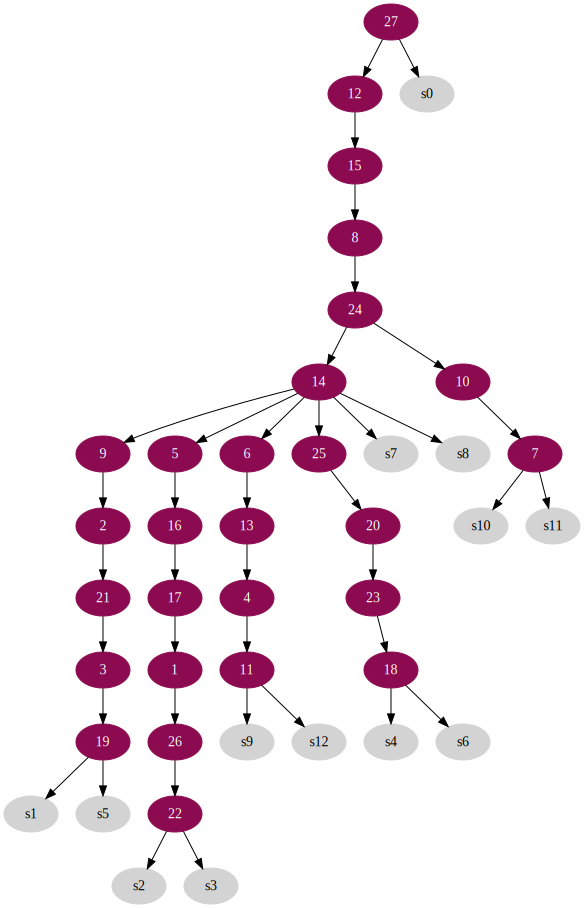

In [317]:
Source.from_file(f'../../../mt-SCITE/mt-SCITE_output/P9855/0.0008_1_map0.gv')

In [256]:
# Plot a tree
# Source.from_file(f'../../../mt-SCITE/mt-SCITE_output/P9855_mrate_1000/0.0005_10_map0.gv')

In [257]:
#pd.set_option('display.max_rows', None)
#performance

In [258]:
performance.head(10)

lhood  n_trees error_rate  n_muts  entries  lhood_entries  \
run                                                                          
0.0001_1  -1543.468818        1     0.0001     176     2288      -0.674593   
0.0001_10 -1584.845425        8     0.0001     176     2288      -0.692677   
0.0001_2  -1485.240456       34     0.0001     176     2288      -0.649144   
0.0001_3  -1547.046870       33     0.0001     176     2288      -0.676157   
0.0001_4  -1533.801790        9     0.0001     176     2288      -0.670368   
0.0001_5  -1506.475383        2     0.0001     176     2288      -0.658425   
0.0001_6  -1577.943187       13     0.0001     176     2288      -0.689660   
0.0001_7  -1554.487747        4     0.0001     176     2288      -0.679409   
0.0001_8  -1566.128308       16     0.0001     176     2288      -0.684497   
0.0001_9  -1494.068847       29     0.0001     176     2288      -0.653002   

           avg_purity_more_than_one_sample  \
run                                          
0.0001_1                          0.898839   
0.0001_10                         0.831597   
0.0001_2                          0.778322   
0.0001_3                          0.644250   
0.0001_4                          0.780072   
0.0001_5                          0.777345   
0.0001_6                          0.568270   
0.0001_7                          0.666241   
0.0001_8                          0.685020   
0.0001_9                          0.779436   

           frac_purity_100_more_than_one_sample  
run                                              
0.0001_1                               0.850746  
0.0001_10                              0.687500  
0.0001_2                               0.647059  
0.0001_3                               0.298246  
0.0001_4                               0.608696  
0.0001_5                               0.636364  
0.0001_6                               0.306122  
0.0001_7                               0.410714  
0.0001_8                               0.458333  
0.0001_9                               0.656716

In [26]:
performance[performance.index.str.contains('0.0008')]

lhood  n_trees error_rate  n_muts  entries  lhood_entries  \
run                                                                        
0.0008_1  -35.299918      119     0.0008      26      338      -0.104438   
0.0008_10 -35.299918      118     0.0008      26      338      -0.104438   
0.0008_2  -35.299918      128     0.0008      26      338      -0.104438   
0.0008_3  -35.299918      100     0.0008      26      338      -0.104438   
0.0008_4  -35.299918      109     0.0008      26      338      -0.104438   
0.0008_5  -35.299918      131     0.0008      26      338      -0.104438   
0.0008_6  -35.299918      138     0.0008      26      338      -0.104438   
0.0008_7  -35.299918      129     0.0008      26      338      -0.104438   
0.0008_8  -35.299918      116     0.0008      26      338      -0.104438   
0.0008_9  -35.299918       72     0.0008      26      338      -0.104438   

           avg_purity_more_than_one_sample  \
run                                          
0.0008_1                          0.963636   
0.0008_10                         0.963636   
0.0008_2                          0.963636   
0.0008_3                          0.963636   
0.0008_4                          0.963636   
0.0008_5                          0.963636   
0.0008_6                          0.963636   
0.0008_7                          0.963636   
0.0008_8                          0.963636   
0.0008_9                          0.963636   

           frac_purity_100_more_than_one_sample  
run                                              
0.0008_1                               0.954545  
0.0008_10                              0.954545  
0.0008_2                               0.954545  
0.0008_3                               0.954545  
0.0008_4                               0.954545  
0.0008_5                               0.954545  
0.0008_6                               0.954545  
0.0008_7                               0.954545  
0.0008_8                               0.954545  
0.0008_9                               0.954545

## Tree Likelihood

In [259]:
#with plot_style(figsize=(5, 3), ticklabelsize=10, labelsize=10):
#    sns.lineplot(data=performance, x="error_rate", y="lhood", lw=1) #marker='o'
#    plt.grid(axis='both')
#    #ax.set_xlim(0, 20)
#    plt.xticks(rotation=90)
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#    plt.ylabel('Best likelihood')
#    plt.xlabel('Error rate')

In [260]:
#with plot_style(figsize=(40, 5), ticklabelsize=10, labelsize=10):
#    sns.lineplot(data=performance, x="error_rate", y="lhood_entries", lw=1) #marker='o'
#    plt.grid(axis='both')
    #ax.set_xlim(0, 20)
#    plt.xticks(rotation=90)
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#    plt.ylabel('Best likelihood / matrix entries')
#    plt.xlabel('Error rate')

#plt.savefig(f'../../data/P9855_figures/lhood_entries.svg', dpi=300, bbox_inches='tight', transparent=True)
#plt.savefig(f'../../data/P9855_figures/lhood_entries.jpg', dpi=300, bbox_inches='tight', transparent=True)

## Average purity

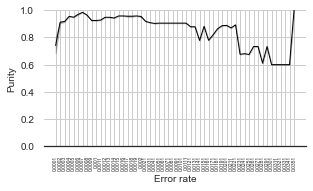

In [37]:
with plot_style(figsize=(4.7, 2.5), ticklabelsize=10, labelsize=10): #4.7
    sns.lineplot(data=performance, x="error_rate", y="avg_purity_more_than_one_sample", lw=1, color='black')
    plt.grid(axis='both')
    plt.xticks(rotation=90)
    plt.ylim(0, 1)
    plt.xticks(fontsize=5)
    
    #plt.xlim(0.0001, 0.0008)
    plt.ylabel('Purity')
    plt.xlabel('Error rate')
    #plt.show()
    
    
    plt.savefig(f'../../data/P9855_figures/purity.pdf', dpi=300, bbox_inches='tight', transparent=True)
    
    

In [60]:
#error_rate_values = performance['error_rate']

# Calculate the number of labels you want (in this case, 10)
#num_labels = 100

# Calculate the step size to evenly distribute the labels
#step_size = len(error_rate_values) // num_labels

# Get the indices for the x-axis ticks
#x_tick_indices = np.arange(0, len(error_rate_values), step_size)

# Get the corresponding error_rate values for the x-axis labels
#x_tick_labels = error_rate_values.iloc[x_tick_indices]

# Your plot code here
#with plot_style(figsize=(20, 2.7), ticklabelsize=10, labelsize=10):
##    sns.lineplot(data=performance, x="error_rate", y="avg_purity_more_than_one_sample", lw=1, color='black')
#    plt.grid(axis='both')
#    plt.xticks(x_tick_indices, x_tick_labels, rotation=90)  # Set the custom tick positions and labels
#    plt.ylabel('Purity')
#    plt.xlabel('Error rate')

# Show or save the plot
#plt.show()

## Number of mutations

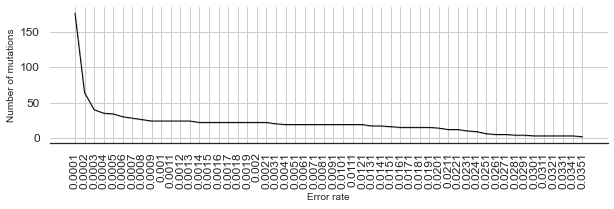

In [25]:
with plot_style(figsize=(10, 2.5), ticklabelsize=10, labelsize=10):
    sns.lineplot(data=performance, x="error_rate", y="n_muts", lw=1, color='Black') #marker='o'
    plt.grid(axis='both')
    #ax.set_xlim(0, 20)
    #plt.yscale("log")
    plt.xticks(rotation=90)
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.ylabel('Number of mutations')
    plt.xlabel('Error rate')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    # Get the x-axis values and labels
    #x_values = performance["error_rate"]
    #x_labels = performance["error_rate"]

    # Plot only every 10th x-axis label
    #step = 200
    #plt.xticks(x_values[::step], x_labels[::step])
    
    #plt.show()
    plt.savefig(f'../../data/P9855_figures/n_muts.svg', dpi=300, bbox_inches='tight', transparent=True)
    #plt.savefig(f'../../data/P9855_figures/n_muts.jpg', dpi=300, bbox_inches='tight', transparent=True)

## Number of trees

In [267]:
performance.rename(columns={'n trees': 'n_trees'}, inplace=True)

In [268]:
performance

lhood  n_trees error_rate  n_muts  entries  lhood_entries  \
run                                                                          
0.0001_1  -1543.468818        1     0.0001     176     2288      -0.674593   
0.0001_10 -1584.845425        8     0.0001     176     2288      -0.692677   
0.0001_2  -1485.240456       34     0.0001     176     2288      -0.649144   
0.0001_3  -1547.046870       33     0.0001     176     2288      -0.676157   
0.0001_4  -1533.801790        9     0.0001     176     2288      -0.670368   
0.0001_5  -1506.475383        2     0.0001     176     2288      -0.658425   
0.0001_6  -1577.943187       13     0.0001     176     2288      -0.689660   
0.0001_7  -1554.487747        4     0.0001     176     2288      -0.679409   
0.0001_8  -1566.128308       16     0.0001     176     2288      -0.684497   
0.0001_9  -1494.068847       29     0.0001     176     2288      -0.653002   
0.0002_1   -357.612696        2     0.0002      64      832      -0.429823   
0.0002_10  -355.643034        6     0.0002      64      832      -0.427456   
0.0002_2   -360.549591        1     0.0002      64      832      -0.433353   
0.0002_3   -346.779408       32     0.0002      64      832      -0.416802   
0.0002_4   -381.128681        5     0.0002      64      832      -0.458087   
0.0002_5   -353.724156        1     0.0002      64      832      -0.425149   
0.0002_6   -367.149670       10     0.0002      64      832      -0.441286   
0.0002_7   -354.446016        6     0.0002      64      832      -0.426017   
0.0002_8   -360.005525        9     0.0002      64      832      -0.432699   
0.0002_9   -364.055019       10     0.0002      64      832      -0.437566   
0.0003_1   -135.119598       94     0.0003      40      520      -0.259845   
0.0003_10  -128.776997        3     0.0003      40      520      -0.247648   
0.0003_2   -128.776997        4     0.0003      40      520      -0.247648   
0.0003_3   -128.776997       81     0.0003      40      520      -0.247648   
0.0003_4   -135.119598        1     0.0003      40      520      -0.259845   
0.0003_5   -135.119598        3     0.0003      40      520      -0.259845   
0.0003_6   -134.037400        9     0.0003      40      520      -0.257764   
0.0003_7   -151.292210        1     0.0003      40      520      -0.290947   
0.0003_8   -128.776997       12     0.0003      40      520      -0.247648   
0.0003_9   -128.776997        1     0.0003      40      520      -0.247648   
0.0004_1   -131.616646       65     0.0004      35      455      -0.289267   
0.0004_10  -131.616646        6     0.0004      35      455      -0.289267   
0.0004_2   -131.616646       12     0.0004      35      455      -0.289267   
0.0004_3   -131.616646       21     0.0004      35      455      -0.289267   
0.0004_4   -131.616646       15     0.0004      35      455      -0.289267   
0.0004_5   -131.616646       34     0.0004      35      455      -0.289267   
0.0004_6   -131.616646        4     0.0004      35      455      -0.289267   
0.0004_7   -131.616646       41     0.0004      35      455      -0.289267   
0.0004_8   -131.616646       41     0.0004      35      455      -0.289267   
0.0004_9   -131.616646       30     0.0004      35      455      -0.289267   
0.0005_1    -95.683468       11     0.0005      34      442      -0.216478   
0.0005_10  -100.221095        3     0.0005      34      442      -0.226745   
0.0005_2    -95.683468       34     0.0005      34      442      -0.216478   
0.0005_3    -95.683468       12     0.0005      34      442      -0.216478   
0.0005_4    -95.683468       11     0.0005      34      442      -0.216478   
0.0005_5    -95.683468        1     0.0005      34      442      -0.216478   
0.0005_6    -95.683468        1     0.0005      34      442      -0.216478   
0.0005_7    -95.683468        9     0.0005      34      442      -0.216478   
0.0005_8    -95.683468       13     0.0005      34      442      -0.216478   
0.0005_9   -100.221095        1     0.0

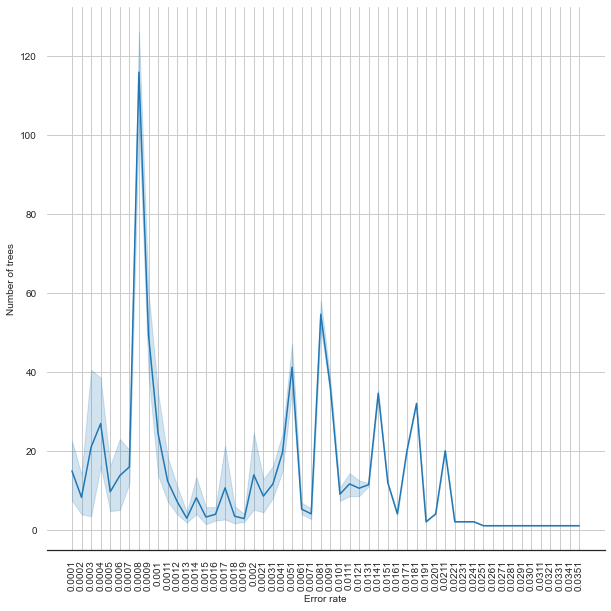

In [269]:
with plot_style(figsize=(10, 10), ticklabelsize=10, labelsize=10):

    sns.lineplot(data=performance.reset_index(), x='error_rate', y="n_trees")

    plt.grid(axis='both')
    #plt.yscale('log')
    plt.xlabel('Error rate')
    plt.ylabel('Number of trees')
    plt.xticks(rotation = 90)
    
    
    # Get the x-axis values and labels
    #x_values = performance["error_rate"]
    #x_labels = performance["error_rate"]

    # Plot only every 250th x-axis label
    #step = 200
    #plt.xticks(x_values[::step], x_labels[::step])
    
    plt.show()
    
    #plt.savefig(f'../../data/P9855_figures/n_trees.svg', dpi=300, bbox_inches='tight', transparent=True)
    #plt.savefig(f'../../data/P9855_figures/n_trees.jpg', dpi=300, bbox_inches='tight', transparent=True)